# Mapping digit-representations in the human primary somatosensory cortex and their layer-dependent functional connectivity at 7T.
## Preprocessing

In this notebook, we are describing and, where possible, performing the preprocessing of this publication.

In [16]:
# basic
import glob
import itertools
import pandas as pd
import numpy as np
import os

# plotting
from nilearn import plotting
from scipy import ndimage
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt

# neuroimaging
from nilearn.connectome import ConnectivityMeasure
import nibabel as nb
from nibabel import load, save, Nifti1Image
import nipype.interfaces.fsl as fsl
import nilearn
import ants

# misc
from scipy.ndimage import morphology
from scipy import stats
from scipy import interpolate


%matplotlib inline

210806-20:37:45,563 nipype.utils INFO:
	 Running nipype version 1.4.2 (latest: 1.5.1)


## locating the data

Because the data location will be different for every machine, we will first define a root folder that we will use from then on.

In [ ]:
root = '/media/sebastian/Data/S1ANFUNCO/raw_data'

In this folder, we will find the find the DICOMs, the nifti data in BIDS format in the "S1ANFUNCO_BIDS" folder and the derivatives folder, which will contain our processed data and analyses.


Next, we can make a list of participant-identifiers:

In [ ]:
subFolders = sorted(glob.glob(root + '/S1ANFUNCO_BIDS/sub*'))
subs = [i[-6:] for i in subFolders]

In [ ]:
subs

In [ ]:
sessFolders = sorted(glob.glob(root + '/S1ANFUNCO_BIDS/sub*/*'))
sessFolders

What comes to mind immediately are the participant and session numbers. When scanning the first 5 subjects, we tested different imaging-parameters and stimulation protocols. Therefore, the subjects are either not included or were reinvited for at a later time. Hence, the higher session numbers in sub-02 and sub-05.

In the derivatives folder, we will have to make a new folder for each subject.

In [ ]:
%%bash -s "{" ".join(subs)}" "$root"

for sub in $1
do
mkdir $2/derivatives/$sub
mkdir $2/derivatives/$sub/anat
mkdir $2/derivatives/$sub/func
mkdir $2/derivatives/$sub/func/rest
mkdir $2/derivatives/$sub/func/stim
done

## Motion correction

To account for non-linear distortions due to low bandwidth, a manually drawn motion mask covering the postcentral gyrus was used to optimize registration on our target region. Mask selection was guided by the raw EPI data and they can be inspected in the derivatives folder.

In [ ]:
motionMasks = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-*/sub-*_moma.nii'))
restRuns = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-*/ses-00*/func/sub-*_ses-00*_task-restBA3b_run-001_cbv.nii.gz'))

for restRun, motionMask in zip(restRuns,motionMasks):

    underlay = nb.load(restRun).get_fdata()[:,:,:,0]
    
    display = plotting.plot_roi(motionMask, underlay, display_mode='z')

### Resting state

For each subject, we want to register all runs to the resting state data. Therefore, we will first do the motion correction for those.

To loop properly in bash, I need to create various lists in python first

In [28]:
subFolders = sorted(glob.glob(root + '/S1ANFUNCO_BIDS/sub*'))
subs = [i[-6:] for i in subFolders]
restRuns = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-*/ses-00*/func/sub-*_ses-00*_task-restBA3b_run-001_cbv.nii.gz'))
motionMasks = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-*/sub-*_moma.nii'))
outFolders =  sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-*/func/rest'))

In [ ]:
%%bash -s "{" ".join(subs)}" "{" ".join(restRuns)}" "{" ".join(motionMasks)}" "{" ".join(outFolders)}"


List1=$1
List2=$2
List3=$3
List4=$4

subsList=($List1)
restRunsList=($List2)
momaList=($List3)
outFolders=($List4)

len=${#subsList[@]}
 
for (( j=0; j<$len; j++ ))
do

base=${subsList[$j]}_rest3b_run-001
outFolder=${outFolders[$j]}
echo Current subject: ${subsList[$j]}
echo The resting-state data is: ${restRunsList[$j]}
echo The motion mask is: ${momaList[$j]}
echo The output will be saved here: ${outFolder}
echo The basename of the output is: ${base}
echo #
echo #
echo #

cd ${outFolder}


###########################################
###### parameters that are not used  ######
###########################################

ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=8
export ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS
tr=1
basevol=1000 # ANTs indexing

mkdir -p motionParameters/run-001/nn_motion
mkdir -p motionParameters/run-001/n_motion


###########################################
####### preparig odd and even images ######
###########################################

#for classical Magentom VASO sequences
3dcalc -a ${restRunsList[$j]}'[0..$(2)]' -expr 'a' -prefix ${base}_notnulled.nii -overwrite
3dcalc -a ${restRunsList[$j]}'[1..$(2)]' -expr 'a' -prefix ${base}_nulled.nii -overwrite

# for Terra 7T VASO sequence
#3dcopy $1'[0..$(2)]' nulled.nii
#3dcopy $1'[1..$(2)]' notnulled.nii


# 3dAutomask -prefix moma.nii -peels 3 -dilate 2  notnulled.nii

###########################################
####### Do MOCO on notnulled  #############
###########################################

n_vols=`PrintHeader ${base}_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

echo "seperating $n_vols time steps to save RAM"
ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_notnulled.nii # vol_1000.nii, vol_1001.nii ...
cp vol_1003.nii vol_1000.nii # removing steady state effects
cp vol_1004.nii vol_1001.nii
cp vol_1005.nii vol_1002.nii
3dMean -prefix ${base}_nn_reference.nii vol_1004.nii vol_1005.nii # there is no overwrite here, in case of multiple series
nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "doing the alignemt"
for i in $(eval echo "{$basevol..$nthvol}");
do
antsRegistration \
--dimensionality 3 \
--float 1 \
--collapse-output-transforms 1 \
--output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
--interpolation BSpline[2] \
--use-histogram-matching 1 \
--winsorize-image-intensities [ 0.005,0.995 ] \
-x ${momaList[$i]} \
--initial-moving-transform [ ${base}_nn_reference.nii,vol_${i}.nii,1 ] \
--transform Rigid[ 0.1 ] \
--metric MI[ ${base}_nn_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
--convergence [ 250x100,1e-6,10 ] \
--shrink-factors 2x1 \
--smoothing-sigmas 1x0vox
#--transform SyN[ 0.1,3,0 ] \
#--metric CC[ nn_reference.nii,vol_${i}.nii,1,4 ] \
#--convergence [ 50x0,1e-6,10 ] \
#--shrink-factors 2x1 \
#--smoothing-sigmas 1x0vox
done

echo "reassembling the time points"
ImageMath 4 ${base}_moco_notnulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
mv vol_*.nii motionParameters/run-001/nn_motion
mv vol_*_0GenericAffine.mat motionParameters/run-001/nn_motion
mv vol_*_InverseWarped.nii.gz motionParameters/run-001/nn_motion
mv vol_*_Warped.nii.gz motionParameters/run-001/nn_motion


###########################################
####### Do MOCO on nulled  ################
###########################################

n_vols=`PrintHeader ${base}_nulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

echo "seperating $n_vols time steps to save RAM"
ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_nulled.nii # vol_1000.nii, vol_1001.nii ...
cp vol_1003.nii vol_1000.nii # removing steady state effects
cp vol_1004.nii vol_1001.nii
cp vol_1005.nii vol_1002.nii
3dMean -prefix ${base}_n_reference.nii vol_1004.nii vol_1005.nii # there is no overwrite here, in case of multiple series
nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "doing the alignemt"
for i in $(eval echo "{$basevol..$nthvol}");
do
antsRegistration \
--dimensionality 3 \
--float 1 \
--collapse-output-transforms 1 \
--output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
--interpolation BSpline[2] \
--use-histogram-matching 1 \
--winsorize-image-intensities [ 0.005,0.995 ] \
-x ${momaList[$i]} \
--initial-moving-transform [ ${base}_n_reference.nii,vol_${i}.nii,1 ] \
--transform Rigid[ 0.1 ] \
--metric MI[ ${base}_n_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
--convergence [ 250x100,1e-6,10 ] \
--shrink-factors 2x1 \
--smoothing-sigmas 1x0vox
#--transform SyN[ 0.1,3,0 ] \
#--metric CC[ n_reference.nii,vol_${i}.nii,1,4 ] \
#--convergence [ 50x0,1e-6,10 ] \
#--shrink-factors 2x1 \
#--smoothing-sigmas 1x0voxdone
done
echo "reassembling the time points"
ImageMath 4 ${base}_moco_nulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
mv vol_*.nii motionParameters/run-001/n_motion
mv vol_*_0GenericAffine.mat motionParameters/run-001/n_motion
mv vol_*_Warped.nii.gz motionParameters/run-001/n_motion
mv vol_*_InverseWarped.nii.gz motionParameters/run-001/n_motion


##############################
#### fsl_motion_outliers  ####
##############################

fsl_motion_outliers -i ${base}_nulled.nii -o motionParameters/run-001/${base}_nulled_confounds.txt
fsl_motion_outliers -i ${base}_notnulled.nii -o motionParameters/run-001/${base}_notnulled_confounds.txt


##################################################
#### Temporal upsampling so VASO matches BOLD ####
##################################################

echo "temporal upsampling and shifting happens now"
3dUpsample -overwrite  -datum short -prefix ${base}_Nulled_intemp.nii -n 2 -input ${base}_moco_nulled.nii
3dUpsample -overwrite  -datum short -prefix ${base}_BOLD_intemp.nii   -n 2 -input ${base}_moco_notnulled.nii

##for Magentom clasical VASO sequence
NumVol=`3dinfo -nv ${base}_Nulled_intemp.nii`
3dTcat -overwrite -prefix ${base}_Nulled_intemp.nii ${base}_Nulled_intemp.nii'[0]' ${base}_Nulled_intemp.nii'[0..'`expr $NumVol - 2`']'

echo "I am correcting for the proper TR in the header"
3drefit -TR 1.9295 ${base}_BOLD_intemp.nii
3drefit -TR 1.9295 ${base}_Nulled_intemp.nii

echo "BOLD correction happens now"
LN_BOCO -Nulled ${base}_Nulled_intemp.nii -BOLD ${base}_BOLD_intemp.nii -output ${base}

echo "calculating T1 in EPI space"
3dTcat -prefix combined.nii  ${base}_moco_nulled.nii ${base}_moco_notnulled.nii -overwrite
3dTstat -cvarinv -overwrite  -prefix ${base}_T1w.nii combined.nii
rm combined.nii

echo "curtosis and skew"
LN_SKEW -input ${base}_BOLD_intemp.nii
LN_SKEW -input ${base}_VASO_LN.nii

# The FSL GLM does not seem to like images where values are between 0 and 1. There fore, we are multipolying everything by 100.
fslmaths ${base}_VASO_LN.nii -mul 100 ${base}_VASO_LN_short.nii -odt short


done

### Stimulation 

After the motion correction is completed for the resting state data, we can use the reference images for the stimulation data. However, we have to take care here, because some participants underwent multiple runs of stimulation.

In [ ]:
stimRuns = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-*/ses-00*/func/sub-*_ses-00*_task-stim*_cbv.nii.gz'))
runNumberList = [i[-18:-11] for i in stimRuns]
subList = [i[-43:-37] for i in stimRuns]

In [ ]:
%%bash -s "{" ".join(subList)}" "{" ".join(stimRuns)}" "{" ".join(runNumberList)}" 


List1=$1
List2=$2
List3=$3

subsList=($List1)
stimRunsList=($List2)
runNumberList=($List3)

len=${#subsList[@]}
 
for (( j=0; j<$len; j++ ))
do

base=${subsList[$j]}_stim_${runNumberList[$j]}
outFolder=/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/${subsList[$j]}/func/stim
echo Current subject: ${subsList[$j]}
echo The current stimulation run is: ${stimRunsList[$j]}
echo The motion mask is: /media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/${subsList[$j]}/${subsList[$j]}_moma.nii
echo The output will be saved here: ${outFolder}
echo The basename of the output is: ${base}
echo #
echo #
echo #


cd ${outFolder}


###########################################
###### parameters that are not used  ######
###########################################

ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=8
export ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS
tr=1
basevol=1000 # ANTs indexing

mkdir -p motionParameters/${runNumberList[$j]}/nn_motion
mkdir -p motionParameters/${runNumberList[$j]}/n_motion


###########################################
####### preparig odd and even images ######
###########################################

#for classical Magentom VASO sequences
3dcalc -a ${stimRunsList[$j]}'[0..$(2)]' -expr 'a' -prefix ${base}_notnulled.nii -overwrite
3dcalc -a ${stimRunsList[$j]}'[1..$(2)]' -expr 'a' -prefix ${base}_nulled.nii -overwrite


###########################################
####### Do MOCO on notnulled  #############
###########################################

n_vols=`PrintHeader ${base}_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

echo "seperating $n_vols time steps to save RAM"
ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_notnulled.nii # vol_1000.nii, vol_1001.nii ...
cp vol_1003.nii vol_1000.nii # removing steady state effects
cp vol_1004.nii vol_1001.nii
cp vol_1005.nii vol_1002.nii
nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "doing the alignemt"
for i in $(eval echo "{$basevol..$nthvol}");
do
antsRegistration \
--dimensionality 3 \
--float 1 \
--collapse-output-transforms 1 \
--output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
--interpolation BSpline[2] \
--use-histogram-matching 1 \
--winsorize-image-intensities [ 0.005,0.995 ] \
-x ${momaList[$i]} \
--initial-moving-transform [ ../rest/${subsList[$j]}_rest3b_run-001_nn_reference.nii,vol_${i}.nii,1 ] \
--transform Rigid[ 0.1 ] \
--metric MI[ ../rest/${subsList[$j]}_rest3b_run-001_nn_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
--convergence [ 250x100,1e-6,10 ] \
--shrink-factors 2x1 \
--smoothing-sigmas 1x0vox
#--transform SyN[ 0.1,3,0 ] \
#--metric CC[ nn_reference.nii,vol_${i}.nii,1,4 ] \
#--convergence [ 50x0,1e-6,10 ] \
#--shrink-factors 2x1 \
#--smoothing-sigmas 1x0vox
done

echo "reassembling the time points"
ImageMath 4 ${base}_moco_notnulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
mv vol_*.nii motionParameters/${runNumberList[$j]}/nn_motion
mv vol_*_0GenericAffine.mat motionParameters/${runNumberList[$j]}/nn_motion
mv vol_*_1Warp.nii.gz motionParameters/${runNumberList[$j]}/nn_motion
mv vol_*_1InverseWarp.nii.gz motionParameters/${runNumberList[$j]}/nn_motion
mv vol_*_InverseWarped.nii.gz motionParameters/${runNumberList[$j]}/nn_motion
mv vol_*_Warped.nii.gz motionParameters/${runNumberList[$j]}/nn_motion


###########################################
####### Do MOCO on nulled  ################
###########################################

n_vols=`PrintHeader ${base}_nulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

echo "seperating $n_vols time steps to save RAM"
ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_nulled.nii # vol_1000.nii, vol_1001.nii ...
cp vol_1003.nii vol_1000.nii # removing steady state effects
cp vol_1004.nii vol_1001.nii
cp vol_1005.nii vol_1002.nii
nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "doing the alignemt"
for i in $(eval echo "{$basevol..$nthvol}");
do
antsRegistration \
--dimensionality 3 \
--float 1 \
--collapse-output-transforms 1 \
--output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
--interpolation BSpline[2] \
--use-histogram-matching 1 \
--winsorize-image-intensities [ 0.005,0.995 ] \
-x ${momaList[$i]} \
--initial-moving-transform [ ../rest/${subsList[$j]}_rest3b_run-001_n_reference.nii,vol_${i}.nii,1 ] \
--transform Rigid[ 0.1 ] \
--metric MI[ ../rest/${subsList[$j]}_rest3b_run-001_n_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
--convergence [ 250x100,1e-6,10 ] \
--shrink-factors 2x1 \
--smoothing-sigmas 1x0vox
#--transform SyN[ 0.1,3,0 ] \
#--metric CC[ n_reference.nii,vol_${i}.nii,1,4 ] \
#--convergence [ 50x0,1e-6,10 ] \
#--shrink-factors 2x1 \
#--smoothing-sigmas 1x0voxdone
done
echo "reassembling the time points"
ImageMath 4 ${base}_moco_nulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
mv vol_*.nii motionParameters/${runNumberList[$j]}/n_motion
mv vol_*_0GenericAffine.mat motionParameters/${runNumberList[$j]}/n_motion
mv vol_*_Warped.nii.gz motionParameters/${runNumberList[$j]}/n_motion
mv vol_*__InverseWarped.nii.gz motionParameters/${runNumberList[$j]}/n_motion
mv vol_*_InverseWarped.nii.gz motionParameters/${runNumberList[$j]}/n_motion
mv vol_*_Warped.nii.gz motionParameters/${runNumberList[$j]}/n_motion


##############################
#### fsl_motion_outliers  ####
##############################

fsl_motion_outliers -i ${base}_nulled.nii -o motionParameters/${runNumberList[$j]}/${base}_nulled_confounds.txt
fsl_motion_outliers -i ${base}_notnulled.nii -o motionParameters/${runNumberList[$j]}/${base}_notnulled_confounds.txt



##################################################
#### Temporal upsampling so VASO matches BOLD ####
##################################################

echo "temporal upsampling and shifting happens now"
3dUpsample -overwrite  -datum short -prefix ${base}_Nulled_intemp.nii -n 2 -input ${base}_moco_nulled.nii
3dUpsample -overwrite  -datum short -prefix ${base}_BOLD_intemp.nii   -n 2 -input ${base}_moco_notnulled.nii

##for Magentom clasical VASO sequence
NumVol=`3dinfo -nv ${base}_Nulled_intemp.nii`
3dTcat -overwrite -prefix ${base}_Nulled_intemp.nii ${base}_Nulled_intemp.nii'[0]' ${base}_Nulled_intemp.nii'[0..'`expr $NumVol - 2`']'

echo "I am correcting for the proper TR in the header"
3drefit -TR 1.9295 ${base}_BOLD_intemp.nii
3drefit -TR 1.9295 ${base}_Nulled_intemp.nii

echo "BOLD correction happens now"
LN_BOCO -Nulled ${base}_Nulled_intemp.nii -BOLD ${base}_BOLD_intemp.nii -output ${base}

echo "calculating T1 in EPI space"
3dTcat -prefix combined.nii  ${base}_moco_nulled.nii ${base}_moco_notnulled.nii -overwrite
3dTstat -cvarinv -overwrite  -prefix ${base}_T1w.nii combined.nii
rm combined.nii

echo "curtosis and skew"
LN_SKEW -input ${base}_BOLD_intemp.nii
LN_SKEW -input ${base}_VASO_LN.nii

# The FSL GLM does not seem to like images where values are between 0 and 1. There fore, we are multipolying everything by 100.
fslmaths ${base}_VASO_LN.nii -mul 100 ${base}_VASO_LN_short.nii -odt short




done

## Motion-Parameters

Here, we want to get the motion-parameters. Because ANTs does not save real world parameters, we will transfer the affine matrices into FSL format.

In [ ]:
subFolders = sorted(glob.glob(root + '/S1ANFUNCO_BIDS/sub*'))
subs = [i[-6:] for i in subFolders]
restRuns = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-*/ses-00*/func/sub-*_ses-00*_task-restBA3b_run-001_cbv.nii.gz'))
motionMasks = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-*/sub-*_moma.nii'))
outFolders =  sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-*/func/rest'))

In [ ]:
%%bash -s "{" ".join(subs)}" "{" ".join(restRuns)}" "{" ".join(outFolders)}"


List1=$1
List2=$2
List3=$3


subsList=($List1)
restRunsList=($List2)
outFolders=($List3)

len=${#subsList[@]}


imageTypes=("n" "nn")


for (( j=0; j<$len; j++ ))
do

# base=${subsList[$j]}_rest3b
base=${subsList[$j]}_rest3b_run-001
outFolder=${outFolders[$j]}
echo Current subject: ${subsList[$j]}
echo The output will be saved here: ${outFolder}
echo The basename of the output is: ${base}
echo #
echo #
echo #

cd ${outFolder}

n_vols=`PrintHeader ${base}_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`
num=$((n_vols + 1000))

echo $num

for imageType in "${imageTypes[@]}"
do


for (( k=1000; k<$num; k++ ))
do
ConvertTransformFile \
3 \
''${outFolder}'/motionParameters/run-001/'$imageType'_motion/vol_'$k'_0GenericAffine.mat' \
''${outFolder}'/motionParameters/run-001/'$imageType'_motion/vol_'$k'_0GenericAffine_af.mat' \
--convertToAffineType


c3d_affine_tool \
-ref ''${subsList[$j]}'_rest3b_run-001_'$imageType'_reference.nii' \
-src ''${outFolder}'/motionParameters/run-001/'$imageType'_motion/vol_'$k'.nii' \
-itk ''${outFolder}'/motionParameters/run-001/'$imageType'_motion/vol_'$k'_0GenericAffine_af.mat' -ras2fsl \
-o ''${outFolder}'/motionParameters/run-001/'$imageType'_motion/vol_'$k'_0GenericAffine_FSL.mat' \
-info-full
done

done

done

Then we can read the matrices and extract the motion traces.

Because the output of the cell made the file-size explode, I will supress it here.

In [ ]:
%%capture

lstsubMot  = []
lstsubMot_Nme  = []
lstTR_sub = []
sub_list =[]
modalityList = []

modalities = ["n", 'nn']
modalitiesDict = {'n': 'VASO', 'nn': 'BOLD'}


for sub in subs:
    
    for modality in modalities:
        
        print(sub)
        affinemats = sorted(glob.glob(root + f'/derivatives/{sub}/func/rest/motionParameters/run-001/{modality}_motion/vol_*_0GenericAffine_FSL.mat'))
        print(len(affinemats))

        volids=[]
        for n in range(len(affinemats)):
            volids.append(n+1000)

        for volid in volids:

            # Current mats
            currMats = root + f'/derivatives/{sub}/func/rest/motionParameters/run-001/{modality}_motion/vol_{volid}_0GenericAffine_FSL.mat'

            tmp = fsl.AvScale(all_param=True,mat_file=currMats)

            tmpReadout = tmp.run()

            # Get the rotations (in rads) and translations (in mm) per volume

            aryTmpMot = list(itertools.chain.from_iterable(
                                        [tmpReadout.outputs.translations,
                                         tmpReadout.outputs.rot_angles]))




            # Save the roation and translations
            lstsubMot.append(aryTmpMot)
            lstTR_sub.append([int(volid)+1-1000 for i in range(6)])               
            lstsubMot_Nme.append([f'TX {modalitiesDict[modality]}',f'TY {modalitiesDict[modality]}',f'TZ {modalitiesDict[modality]}',f'RX {modalitiesDict[modality]}',f'RY {modalitiesDict[modality]}',f'RZ {modalitiesDict[modality]}'])
            sub_list.append([str(sub) for i in range(6)])
            modalityList.append([str(modalitiesDict[modality]) for i in range(6)])

Convert the lists into arrays and them make a nice dataframe.

In [ ]:
aryCurr = np.array(lstsubMot)
aryCurr_Ses =  aryCurr.reshape((aryCurr.size,-1))
aryCurr_TR = np.array(lstTR_sub)
aryCurr_TR_Ses = aryCurr_TR.reshape((aryCurr_TR.size,-1))
aryCurr_Nme = np.array(lstsubMot_Nme)
aryCurr_Nme_Ses = aryCurr_Nme.reshape((aryCurr_Nme.size,-1))
aryIdx = np.arange(1,len(aryCurr_Nme_Ses)+1)

aryCurr_mod = np.array(modalityList)
aryCurr_mod = aryCurr_mod.reshape((aryCurr_mod.size,-1))

aryCurr_subname = np.array(sub_list)
aryCurr_subs =  aryCurr_subname.reshape((aryCurr_subname.size,-1))
     
data_dict = {
    'subject': aryCurr_subs[:,0],
    'Time/TR': aryCurr_TR_Ses[:,0],
    'Motion_Name': aryCurr_Nme_Ses[:,0],
    'Motion': aryCurr_Ses[:,0],
    'idx':aryIdx,
    'modality': aryCurr_mod[:,0]}
    
pd_ses = pd.DataFrame(data=data_dict)


Which can then be saved.

In [ ]:
pd_ses.to_csv(root + '/derivatives/quality_assessmen/motionParametersRest.csv', index=False)  

This is then repeated for the stimulation data.

In [ ]:
stimRuns = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-*/ses-00*/func/sub-*_ses-00*_task-stim*_cbv.nii.gz'))
runNumberList = [i[-18:-11] for i in stimRuns]
subList = [i[-43:-37] for i in stimRuns]
outFolders =  sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-*/func/stim/motionParameters/run-00*'))

In [ ]:
%%bash -s "{" ".join(subList)}" "{" ".join(stimRuns)}" "{" ".join(runNumberList)}" "{" ".join(outFolders)}"


List1=$1
List2=$2
List3=$3
List4=$4

subsList=($List1)
stimRunsList=($List2)
runNumberList=($List3)
outFolders=($List4)

len=${#subsList[@]}



imageTypes=("n" "nn")

len=${#subsList[@]}
 

for (( j=0; j<$len; j++ ))
do

base=${subsList[$j]}_stim_${runNumberList[$j]}
outFolder=${outFolders[$j]}
echo Current subject: ${subsList[$j]}
echo The current stimulation run is: ${stimRunsList[$j]}
echo The output will be saved here: ${outFolder}
echo The basename of the output is: ${base}
echo #
echo #
echo #

cd ${outFolder}

n_vols=`PrintHeader ../../${base}_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`
num=$((n_vols + 1000))

echo $num

for imageType in "${imageTypes[@]}"
do


for (( k=1000; k<$num; k++ ))
do
ConvertTransformFile \
3 \
''$imageType'_motion/vol_'$k'_0GenericAffine.mat' \
''$imageType'_motion/vol_'$k'_0GenericAffine_af.mat' \
--convertToAffineType


c3d_affine_tool \
-ref '../../../rest/'${subsList[$j]}'_rest3b_run-001_'$imageType'_reference.nii' \
-src ''$imageType'_motion/vol_'$k'.nii' \
-itk ''$imageType'_motion/vol_'$k'_0GenericAffine_af.mat' -ras2fsl \
-o ''$imageType'_motion/vol_'$k'_0GenericAffine_FSL.mat' \
-info-full
done

done

done

In [17]:
stimRuns = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-*/ses-00*/func/sub-*_ses-00*_task-stim*_cbv.nii.gz'))
runNumberList = [i[-18:-11] for i in stimRuns]
subList = [i[-43:-37] for i in stimRuns]
outFolders =  sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-*/func/stim/motionParameters/run-00*'))

In [ ]:
root = '/media/sebastian/Data/S1ANFUNCO/raw_data'

stimRuns = sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-*/ses-00*/func/sub-*_ses-00*_task-stim*_cbv.nii.gz'))
runNumberList = [i[-18:-11] for i in stimRuns]
subList = [i[-43:-37] for i in stimRuns]
outFolders =  sorted(glob.glob('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-*/func/stim/motionParameters/run-00*'))


modalities = ["n", 'nn']
modalitiesDict = {'n': 'VASO', 'nn': 'BOLD'}



print(modalities)

for sub in np.unique(subList):

    lstsubMot  = []
    lstsubMot_Nme  = []
    lstTR_sub = []
    sub_list =[]
    modalityList = []
    runsList = []

    runs = sorted(glob.glob(root + f'/derivatives/{sub}/func/stim/motionParameters/*'))

    for k in range(1,len(runs)+1):

        for modality in modalities:

            affinemats = sorted(glob.glob(root + f'/derivatives/{sub}/func/stim/motionParameters/run-00{k}/{modality}_motion/vol_*_0GenericAffine_FSL.mat'))
            print(len(affinemats))

            volids=[]
            for n in range(len(affinemats)):
                volids.append(n+1000)

            for volid in volids:
                print(f'{sub}_run-00{k}_{modality}_volume{volid}')

                # Current mats
                currMats = root + f'/derivatives/{sub}/func/stim/motionParameters/run-00{k}/{modality}_motion/vol_{volid}_0GenericAffine_FSL.mat'

                tmp = fsl.AvScale(all_param=True,mat_file=currMats);

                tmpReadout = tmp.run();

                # Get the rotations (in rads) and translations (in mm) per volume

                aryTmpMot = list(itertools.chain.from_iterable([tmpReadout.outputs.translations,tmpReadout.outputs.rot_angles]));




                # Save the roation and translations
                lstsubMot.append(aryTmpMot)
                lstTR_sub.append([int(volid)+1-1000 for i in range(6)])
                lstsubMot_Nme.append([f'TX {modalitiesDict[modality]}',f'TY {modalitiesDict[modality]}',f'TZ {modalitiesDict[modality]}',f'RX {modalitiesDict[modality]}',f'RY {modalitiesDict[modality]}',f'RZ {modalitiesDict[modality]}'])
                sub_list.append([str(sub) for i in range(6)])
                modalityList.append([str(modalitiesDict[modality]) for i in range(6)])
                runsList.append([str(f'run-00{k}') for i in range(6)])




    aryCurr = np.array(lstsubMot)
    aryCurr_Ses =  aryCurr.reshape((aryCurr.size,-1))
    aryCurr_TR = np.array(lstTR_sub)
    aryCurr_TR_Ses = aryCurr_TR.reshape((aryCurr_TR.size,-1))
    aryCurr_Nme = np.array(lstsubMot_Nme)
    aryCurr_Nme_Ses = aryCurr_Nme.reshape((aryCurr_Nme.size,-1))
    aryIdx = np.arange(1,len(aryCurr_Nme_Ses)+1)

    aryCurr_mod = np.array(modalityList)
    aryCurr_mod = aryCurr_mod.reshape((aryCurr_mod.size,-1))

    aryCurr_subname = np.array(sub_list)
    aryCurr_subs =  aryCurr_subname.reshape((aryCurr_subname.size,-1))

    aryCurr_runsList = np.array(runsList)
    aryCurr_runs =  aryCurr_runsList.reshape((aryCurr_runsList.size,-1))



    data_dict = {
        'subject': aryCurr_subs[:,0],
        'Time/TR': aryCurr_TR_Ses[:,0],
        'Motion_Name': aryCurr_Nme_Ses[:,0],
        'Motion': aryCurr_Ses[:,0],
        'idx':aryIdx,
        'modality': aryCurr_mod[:,0],
        'run': aryCurr_runs[:,0]}

    pd_ses = pd.DataFrame(data=data_dict)
    pd_ses.to_csv(root + f'/derivatives/quality_assessmen/{sub}motionParametersStim.csv', index=False)

### Plotting motion

For visual inspection, we can proceed with plotting the motion traces over time.

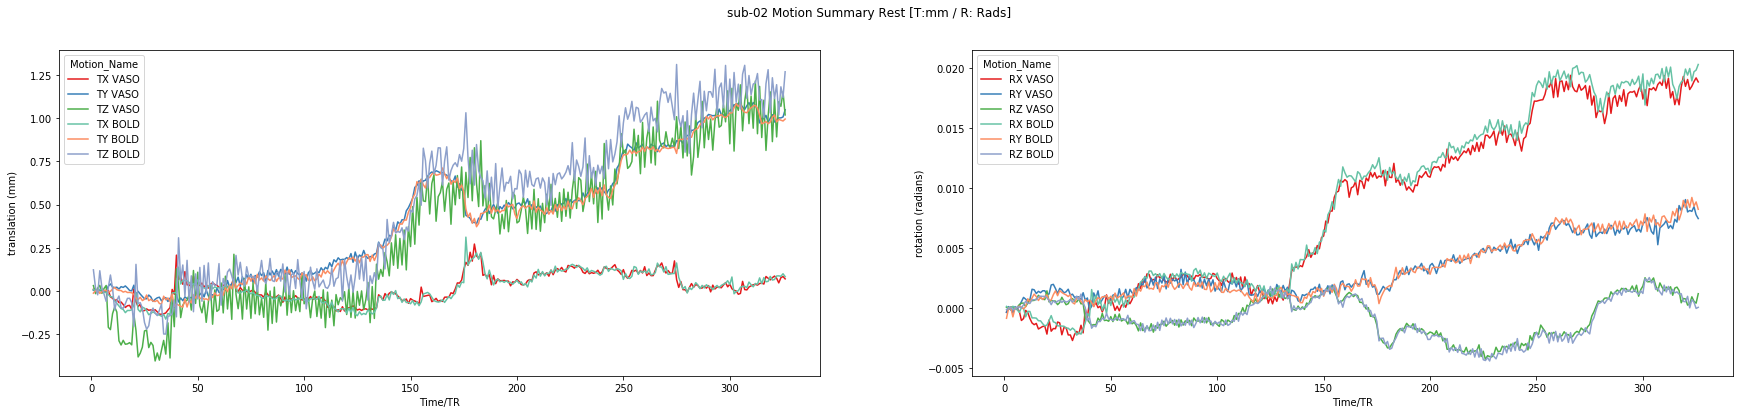

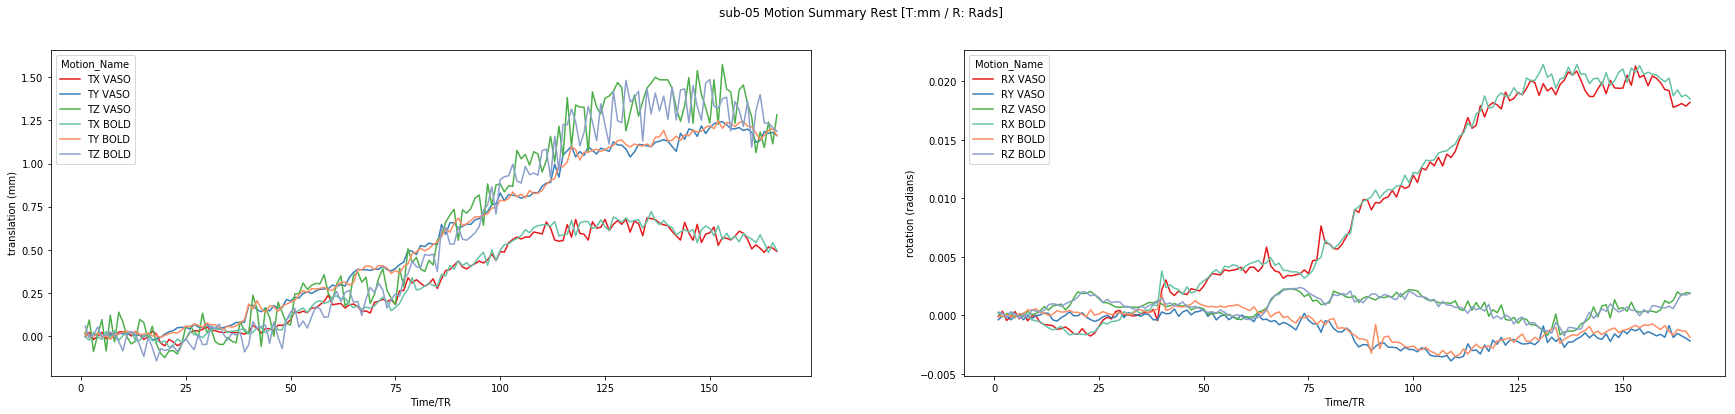

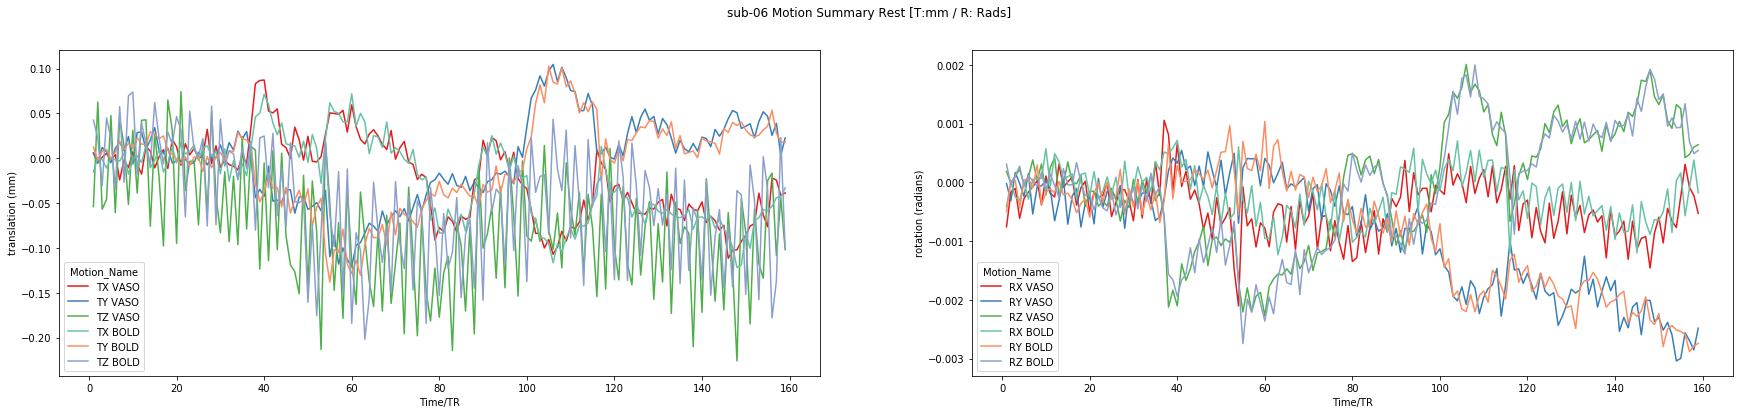

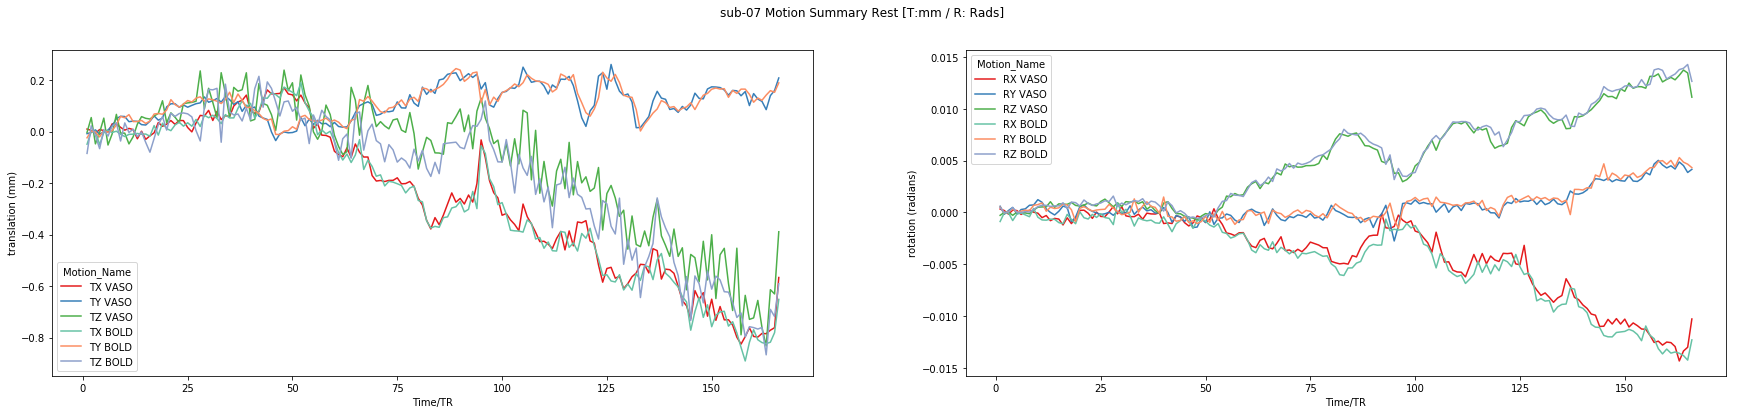

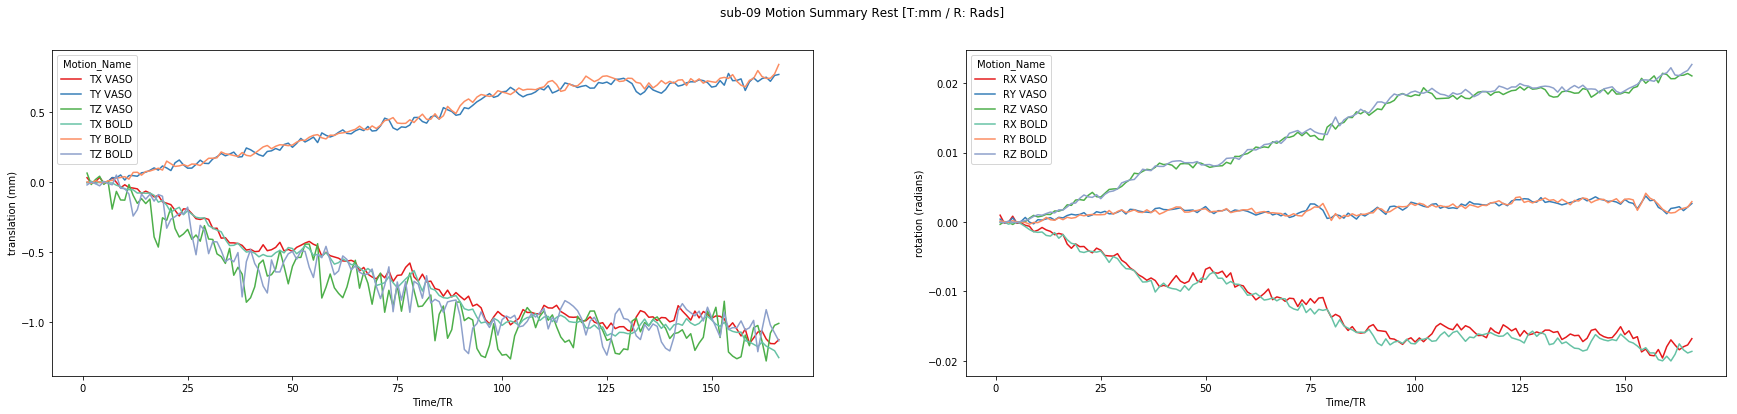

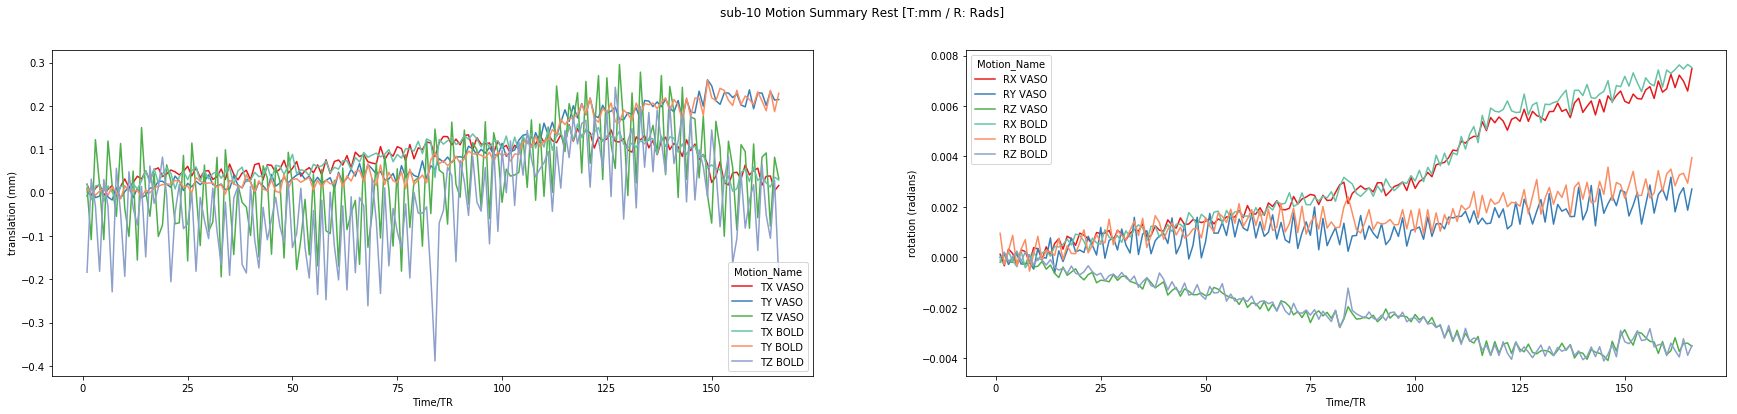

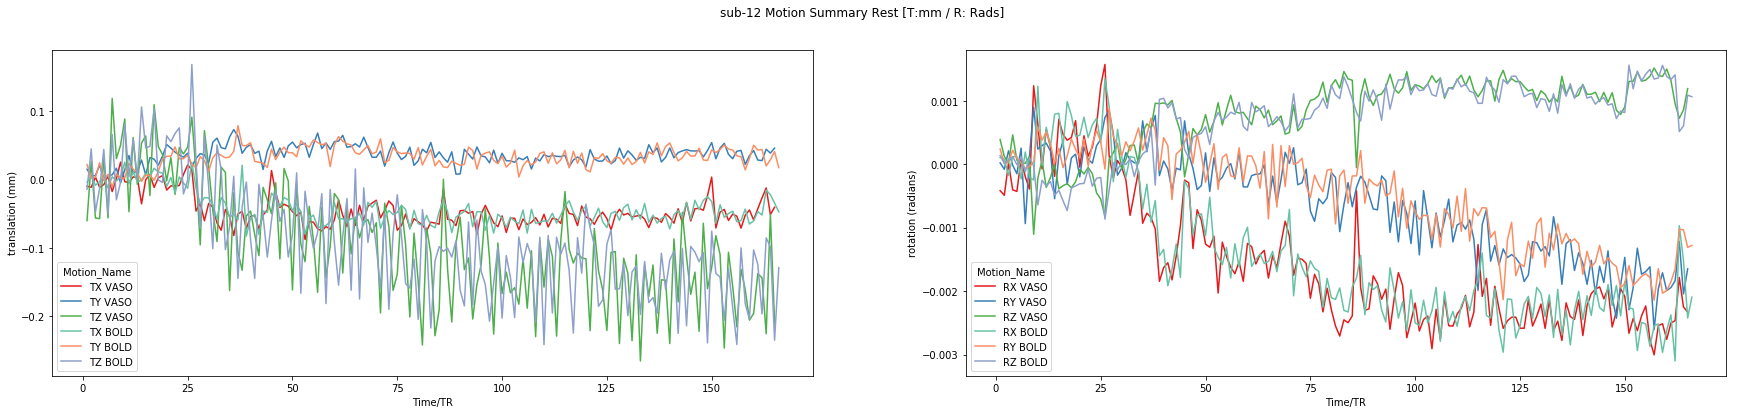

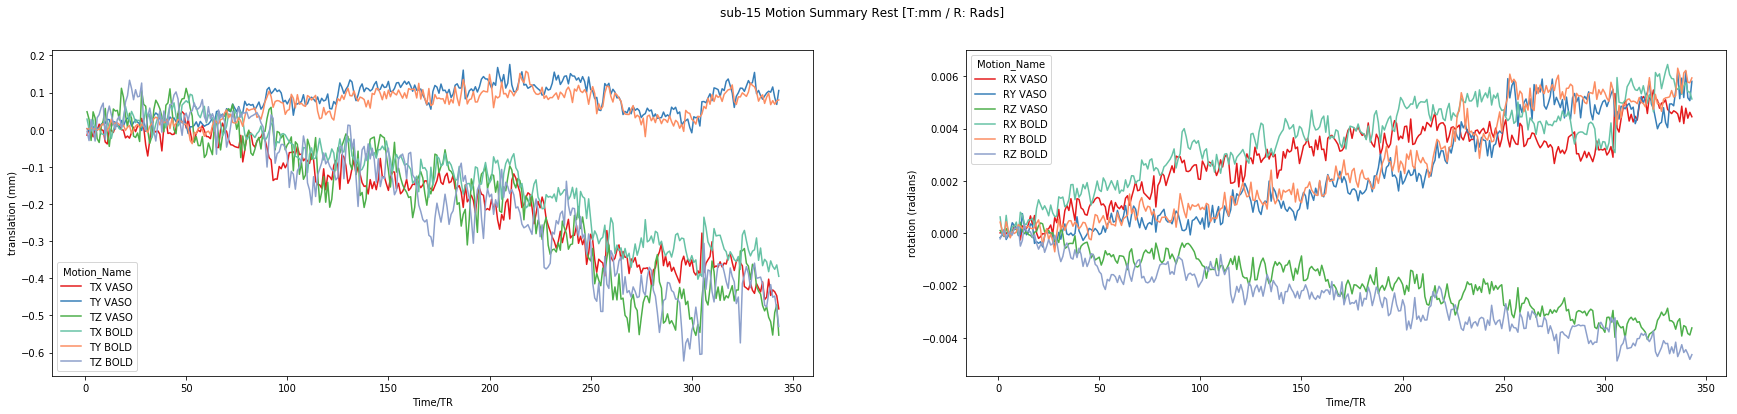

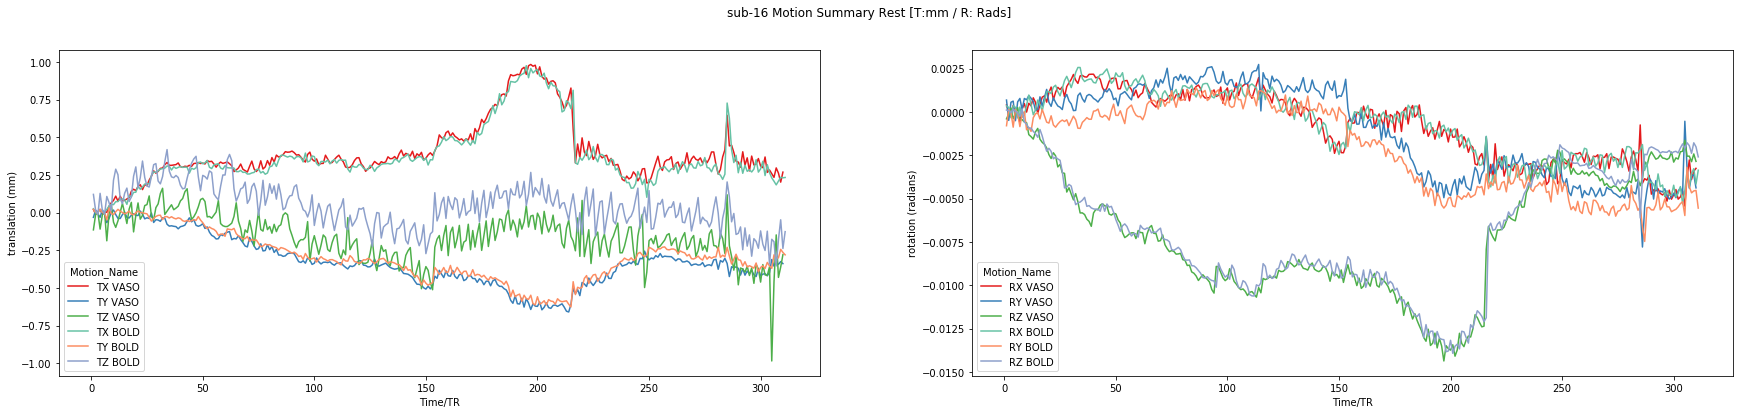

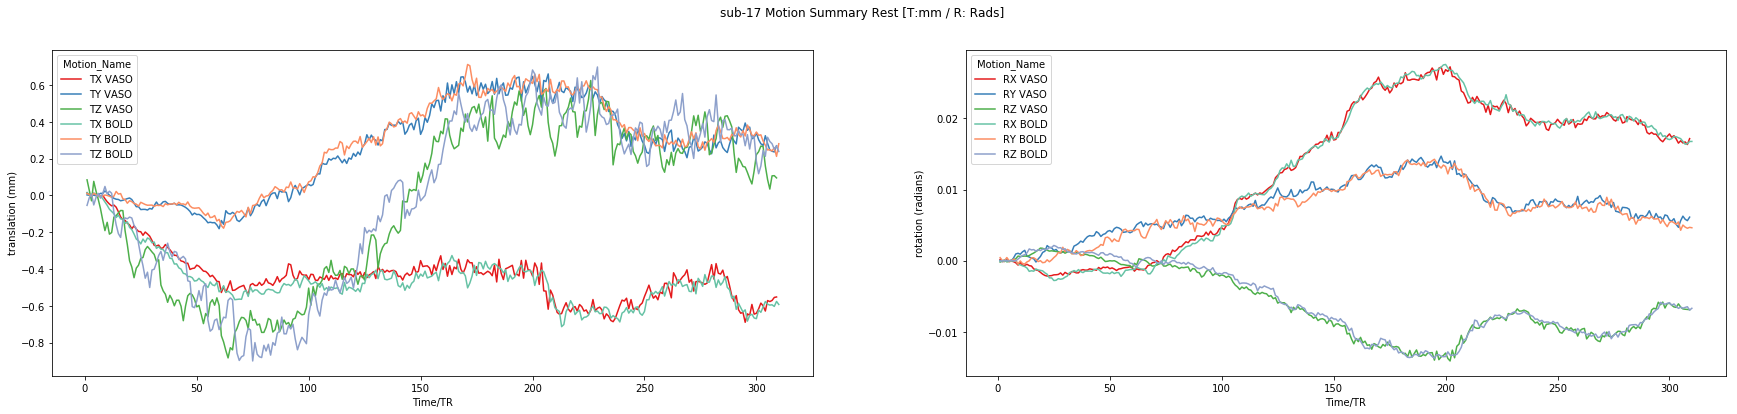

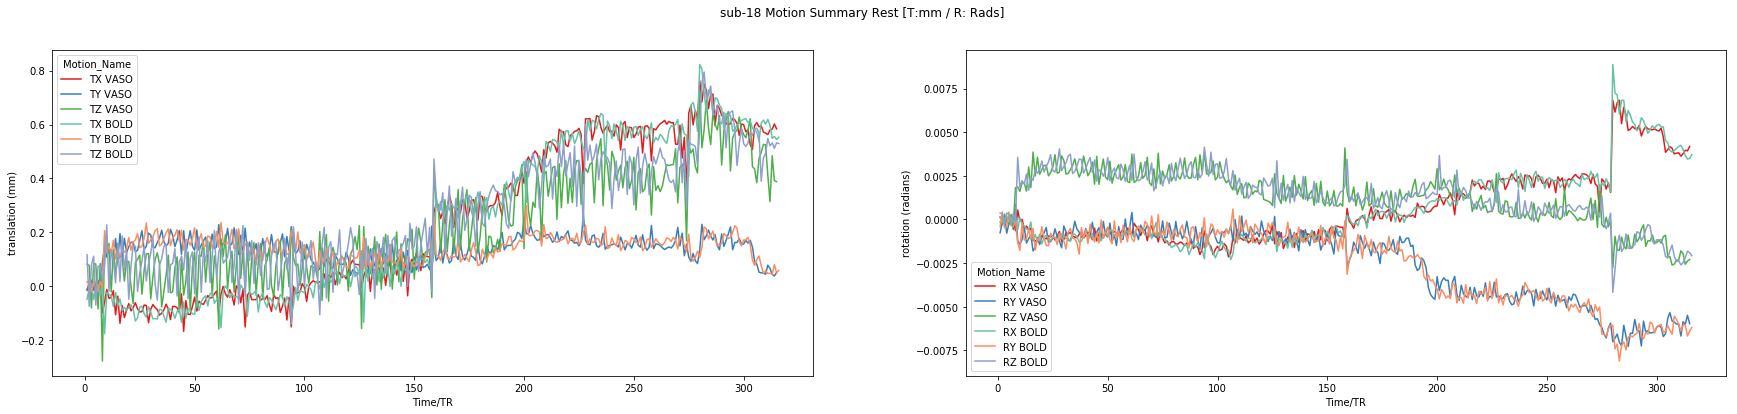

In [60]:
# Load dataFrames
restMotion = pd.read_csv(root + f'/derivatives/quality_assessmen/motionParametersRest.csv')

for sub in subs:
    restMotion_rot_VASO = restMotion.loc[(restMotion['Motion_Name'].str.contains("R") == 1)&(restMotion['subject']==sub)&(restMotion['modality']=='VASO')].dropna()
    restMotion_trans_VASO = restMotion.loc[(restMotion['Motion_Name'].str.contains("T") == 1)&(restMotion['subject']==sub)&(restMotion['modality']=='VASO')].dropna()
    
    restMotion_rot_BOLD = restMotion.loc[(restMotion['Motion_Name'].str.contains("R") == 1)&(restMotion['subject']==sub)&(restMotion['modality']=='BOLD')].dropna()
    restMotion_trans_BOLD = restMotion.loc[(restMotion['Motion_Name'].str.contains("T") == 1)&(restMotion['subject']==sub)&(restMotion['modality']=='BOLD')].dropna()
    
    
    fig, axes = plt.subplots(1, 2,sharex=True,figsize=(30,6))
    plt.suptitle('%s Motion Summary Rest [T:mm / R: Rads]'%(sub))


    sns.lineplot(ax=axes[0], x='Time/TR',y='Motion',data=restMotion_trans_VASO,hue='Motion_Name', palette = 'Set1')
    sns.lineplot(ax=axes[0], x='Time/TR',y='Motion',data=restMotion_trans_BOLD,hue='Motion_Name', palette = 'Set2')


    axes[0].set_ylabel("translation (mm)")


    sns.lineplot(ax=axes[1], x='Time/TR',y='Motion',data=restMotion_rot_VASO,hue='Motion_Name', palette = 'Set1')
    sns.lineplot(ax=axes[1], x='Time/TR',y='Motion',data=restMotion_rot_BOLD,hue='Motion_Name', palette = 'Set2')



    axes[1].set_ylabel("rotation (radians)")
    plt.savefig('/home/sebastian/Desktop/%s_motionRest.jpg'%(sub), bbox_inches = 'tight', pad_inches = 0)

In [45]:
stimMotion

subject  Time/TR Motion_Name    Motion   idx modality      run
0     sub-18        1     TX VASO -0.077648     1     VASO  run-001
1     sub-18        1     TY VASO  0.658644     2     VASO  run-001
2     sub-18        1     TZ VASO  0.778474     3     VASO  run-001
3     sub-18        1     RX VASO  0.001517     4     VASO  run-001
4     sub-18        1     RY VASO  0.003931     5     VASO  run-001
5     sub-18        1     RZ VASO  0.007272     6     VASO  run-001
6     sub-18        2     TX VASO -0.075301     7     VASO  run-001
7     sub-18        2     TY VASO  0.631239     8     VASO  run-001
8     sub-18        2     TZ VASO  0.916922     9     VASO  run-001
9     sub-18        2     RX VASO  0.001684    10     VASO  run-001
10    sub-18        2     RY VASO  0.003481    11     VASO  run-001
11    sub-18        2     RZ VASO  0.006792    12     VASO  run-001
12    sub-18        3     TX VASO -0.133592    13     VASO  run-001
13    sub-18        3     TY VASO  0.661794    14     VASO  run-001
14    sub-18        3     TZ VASO  0.701107    15     VASO  run-001
15    sub-18        3     RX VASO  0.001070    16     VASO  run-001
16    sub-18        3     RY VASO  0.004078    17     VASO  run-001
17    sub-18        3     RZ VASO  0.007758    18     VASO  run-001
18    sub-18        4     TX VASO -0.094855    19     VASO  run-001
19    sub-18        4     TY VASO  0.667363    20     VASO  run-001
20    sub-18        4     TZ VASO  0.747773    21     VASO  run-001
21    sub-18        4     RX VASO  0.001399    22     VASO  run-001
22    sub-18        4     RY VASO  0.004209    23     VASO  run-001
23    sub-18        4     RZ VASO  0.007418    24     VASO  run-001
24    sub-18        5     TX VASO -0.077304    25     VASO  run-001
25    sub-18        5     TY VASO  0.632213    26     VASO  run-001
26    sub-18        5     TZ VASO  0.912431    27     VASO  run-001
27    sub-18        5     RX VASO  0.001677    28     VASO  run-001
28    sub-18        5     RY VASO  0.003542    29     VASO  run-001
29    sub-18        5     RZ VASO  0.006805    30     VASO  run-001
...      ...      ...         ...       ...   ...      ...      ...
7188  sub-18      197     TX BOLD -0.273263  7189     BOLD  run-003
7189  sub-18      197     TY BOLD  0.285930  7190     BOLD  run-003
7190  sub-18      197     TZ BOLD -0.269422  7191     BOLD  run-003
7191  sub-18      197     RX BOLD -0.001141  7192     BOLD  run-003
7192  sub-18      197     RY BOLD -0.001430  7193     BOLD  run-003
7193  sub-18      197     RZ BOLD  0.004547  7194     BOLD  run-003
7194  sub-18      198     TX BOLD -0.266134  7195     BOLD  run-003
7195  sub-18      198     TY BOLD  0.288576  7196     BOLD  run-003
7196  sub-18      198     TZ BOLD -0.289050  7197     BOLD  run-003
7197  sub-18      198     RX BOLD -0.001124  7198     BOLD  run-003
7198  sub-18      198     RY BOLD -0.001337  7199     BOLD  run-003
7199  sub-18      198     RZ BOLD  0.004505  7200     BOLD  run-003
7200  sub-18      199     TX BOLD -0.266158  7201     BOLD  run-003
7201  sub-18      199     TY BOLD  0.267907  7202     BOLD  run-003
7202  sub-18      199     TZ BOLD -0.304007  7203     BOLD  run-003
7203  sub-18      199     RX BOLD -0.001349  7204     BOLD  run-003
7204  sub-18      199     RY BOLD -0.001146  7205     BOLD  run-003
7205  sub-18      199     RZ BOLD  0.004200  7206     BOLD  run-003
7206  sub-18      200     TX BOLD -0.258122  7207     BOLD  run-003
7207  sub-18      200     TY BOLD  0.283292  7208     BOLD  run-003
7208  sub-18      200     TZ BOLD -0.305105  7209     BOLD  run-003
7209  sub-18      200     RX BOLD -0.001742  7210     BOLD  run-003
7210  sub-18      200     RY BOLD -0.001522  7211     BOLD  run-003
7211  sub-18      200     RZ BOLD  0.004483  7212     BOLD  run-003
7212  sub-18      201     TX BOLD -0.258053  7213     BOLD  run-003
7213  sub-18      201     TY BOLD  0.277508  7214     BOLD  run-003
7214  sub-18      201     TZ BOLD -0.480641  7215     BOLD  r

sub-02
2
sub-05
1
sub-06
1
sub-07
2
sub-09
1
sub-10
1
sub-12
4
sub-15
3
sub-16
3
sub-17
3
sub-18
3


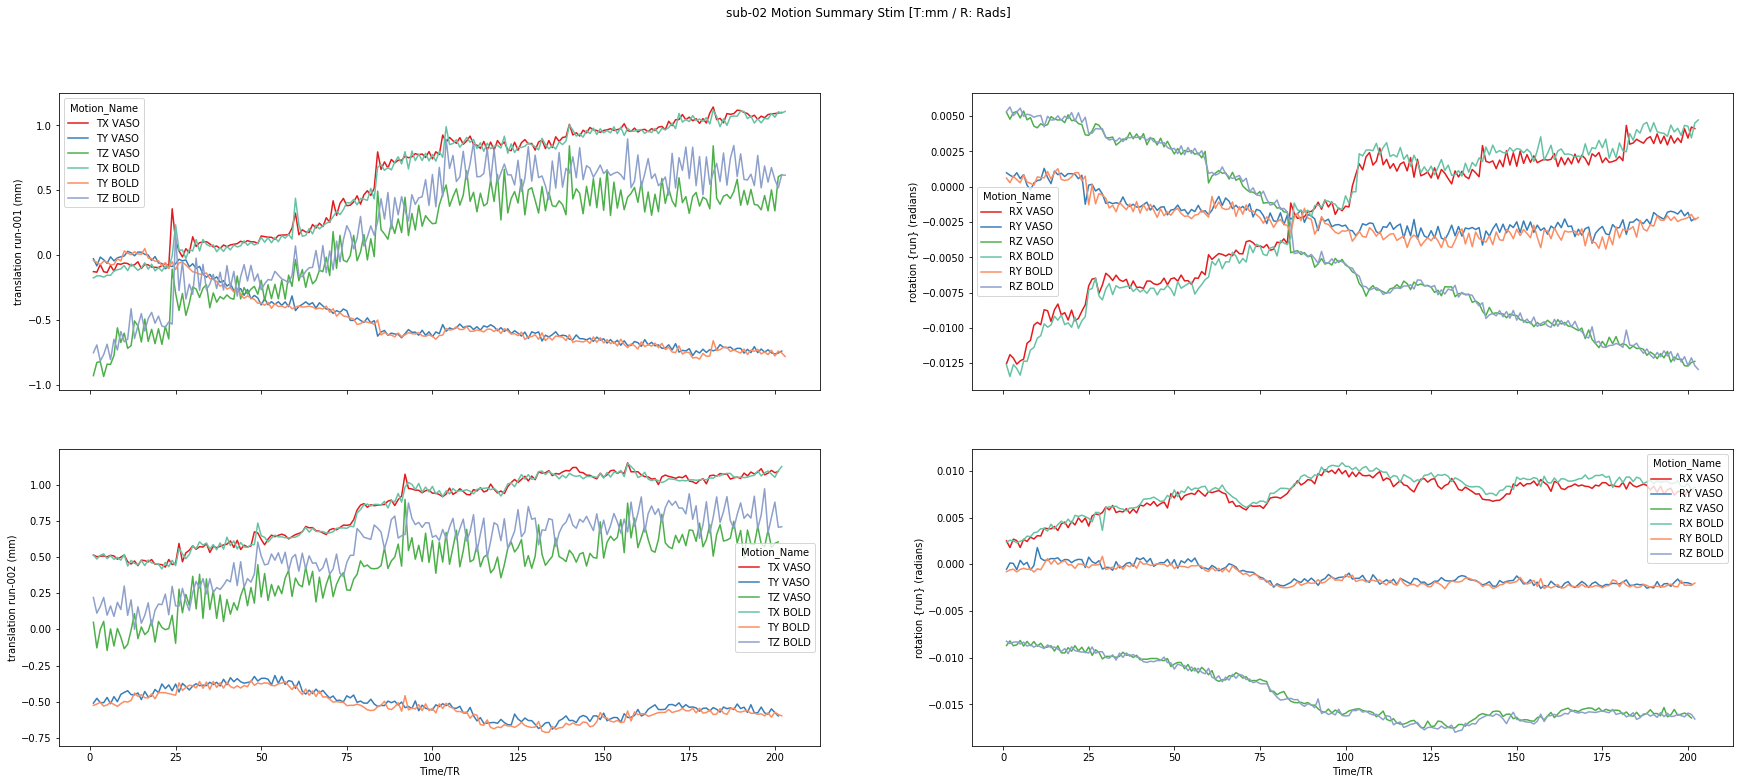

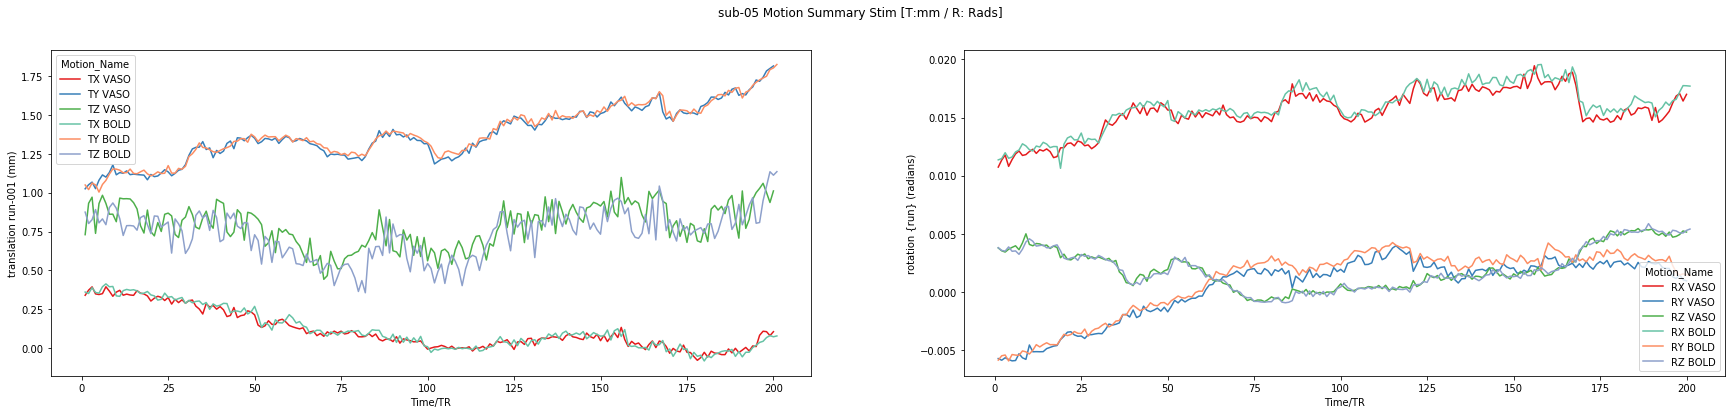

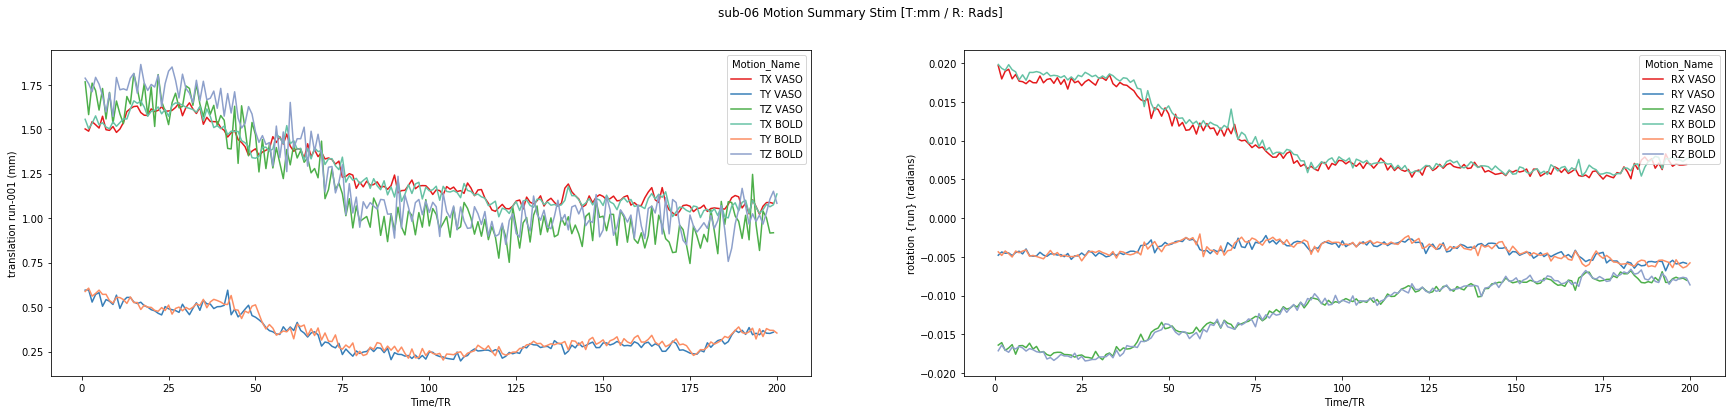

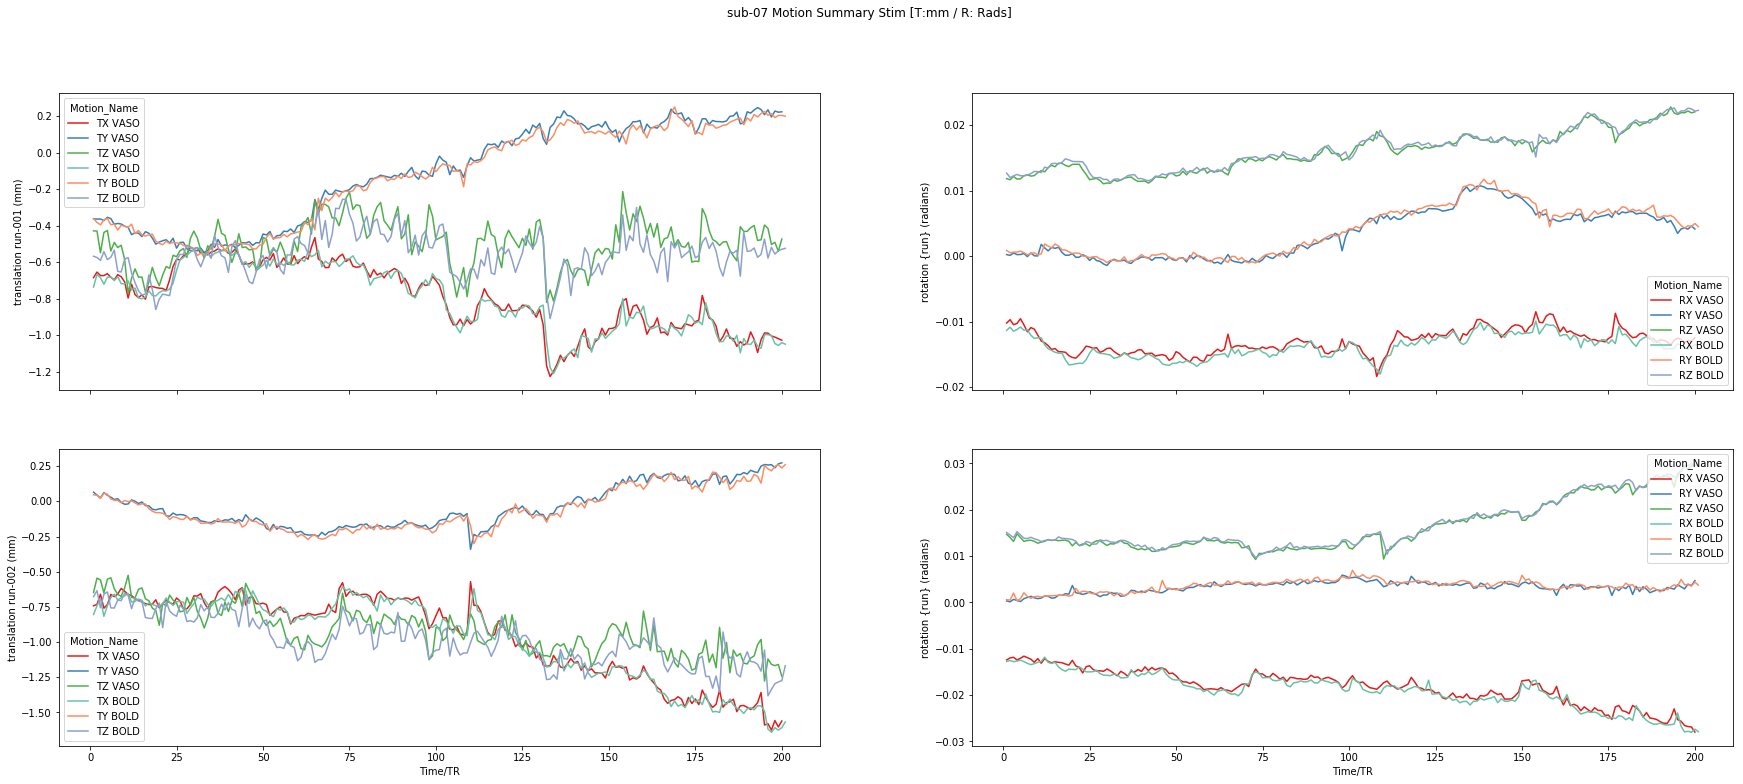

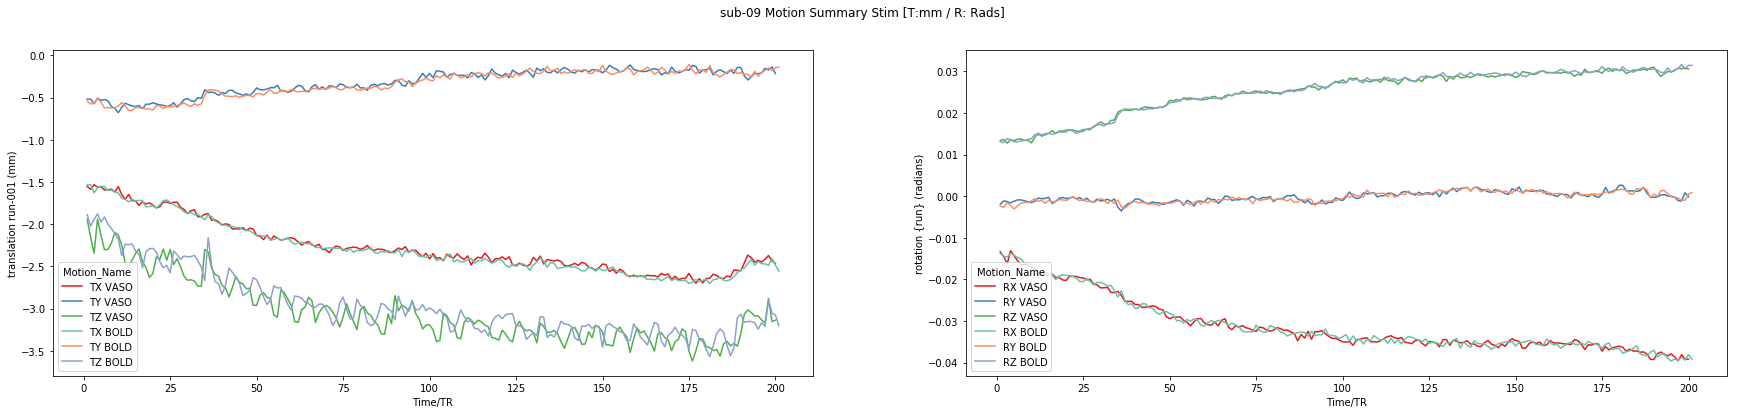

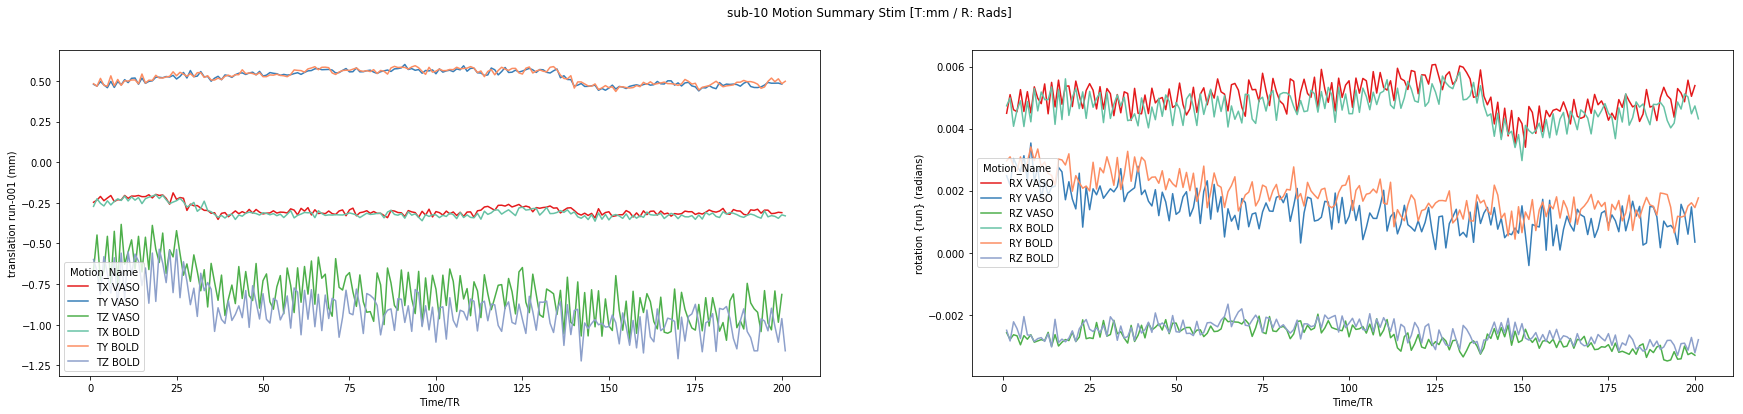

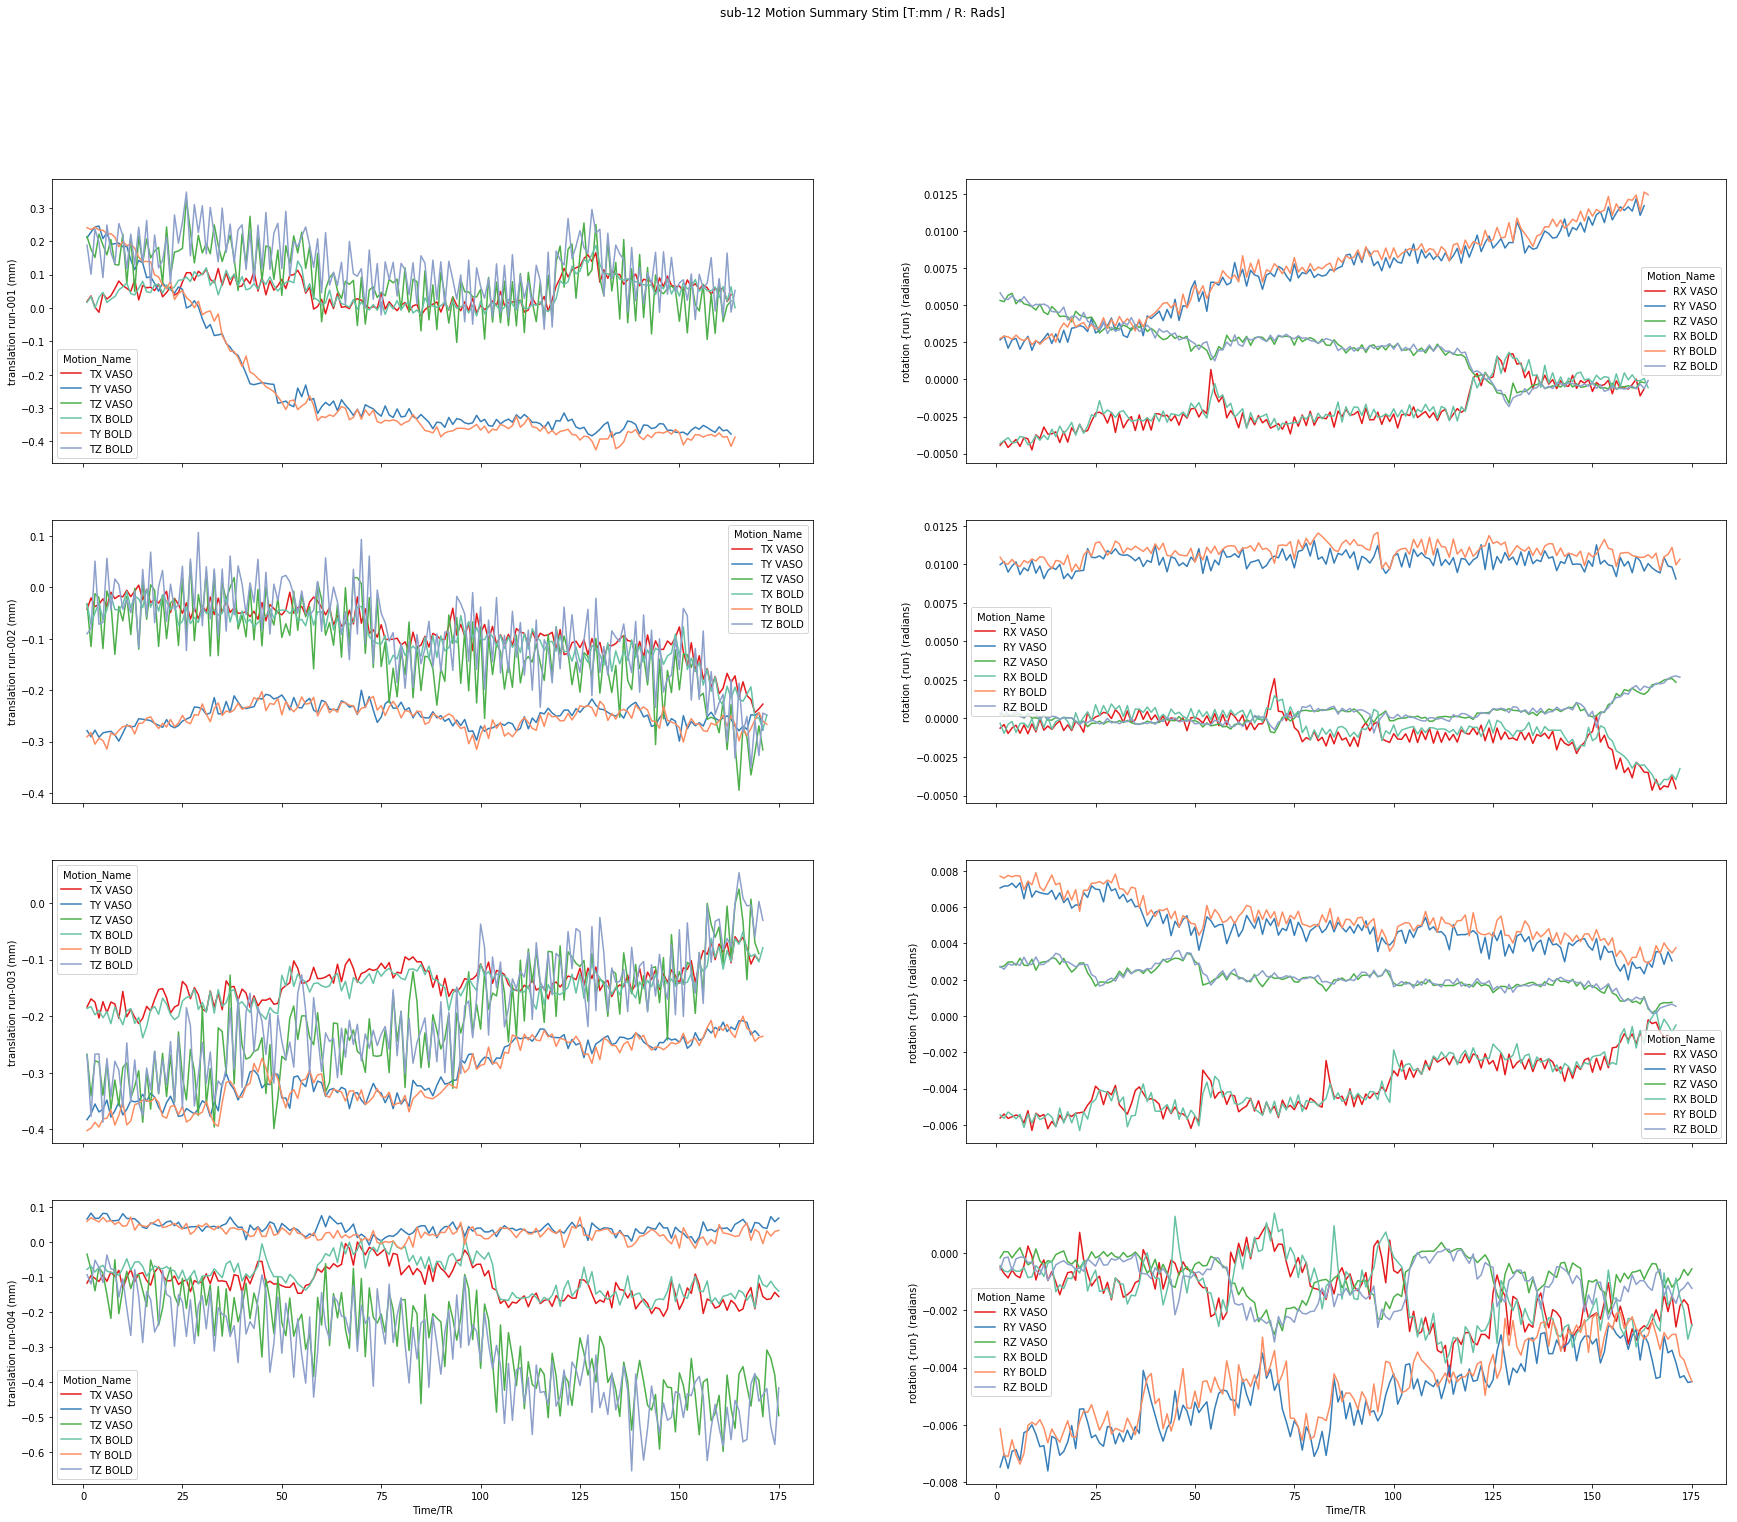

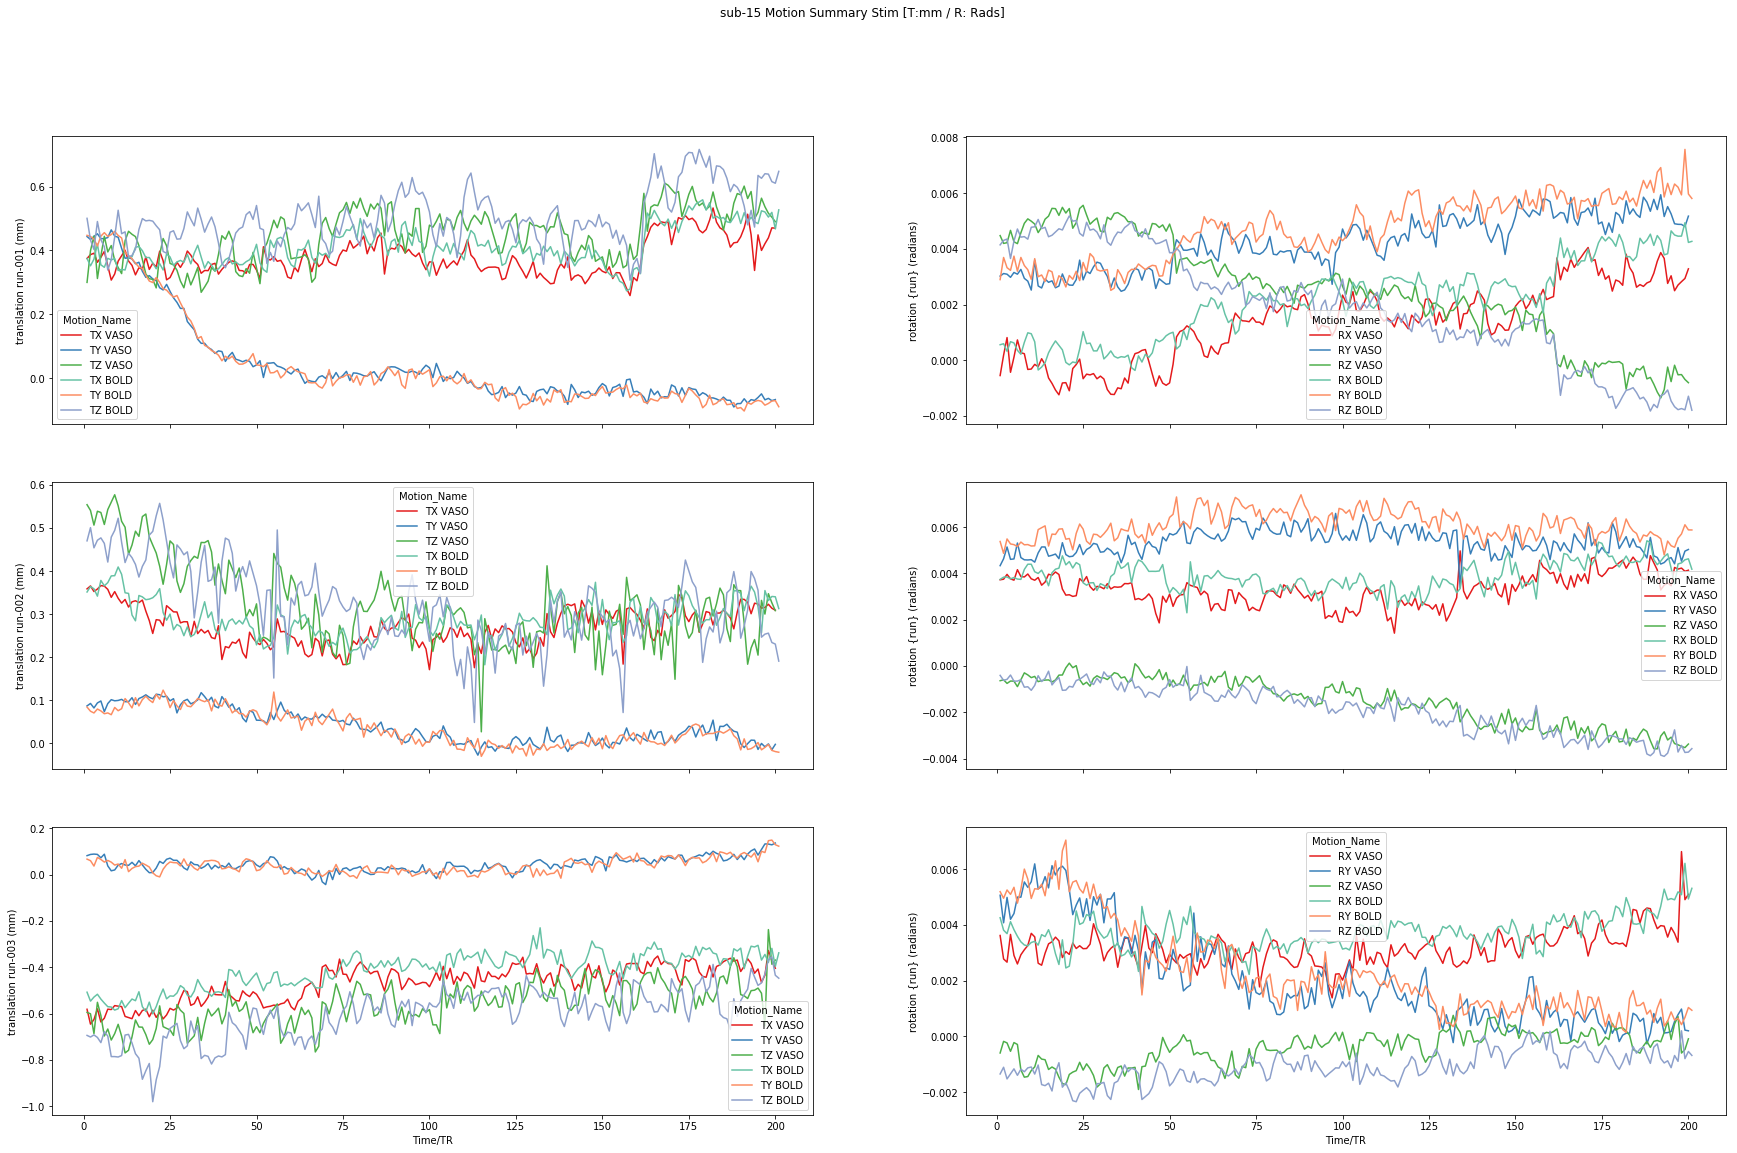

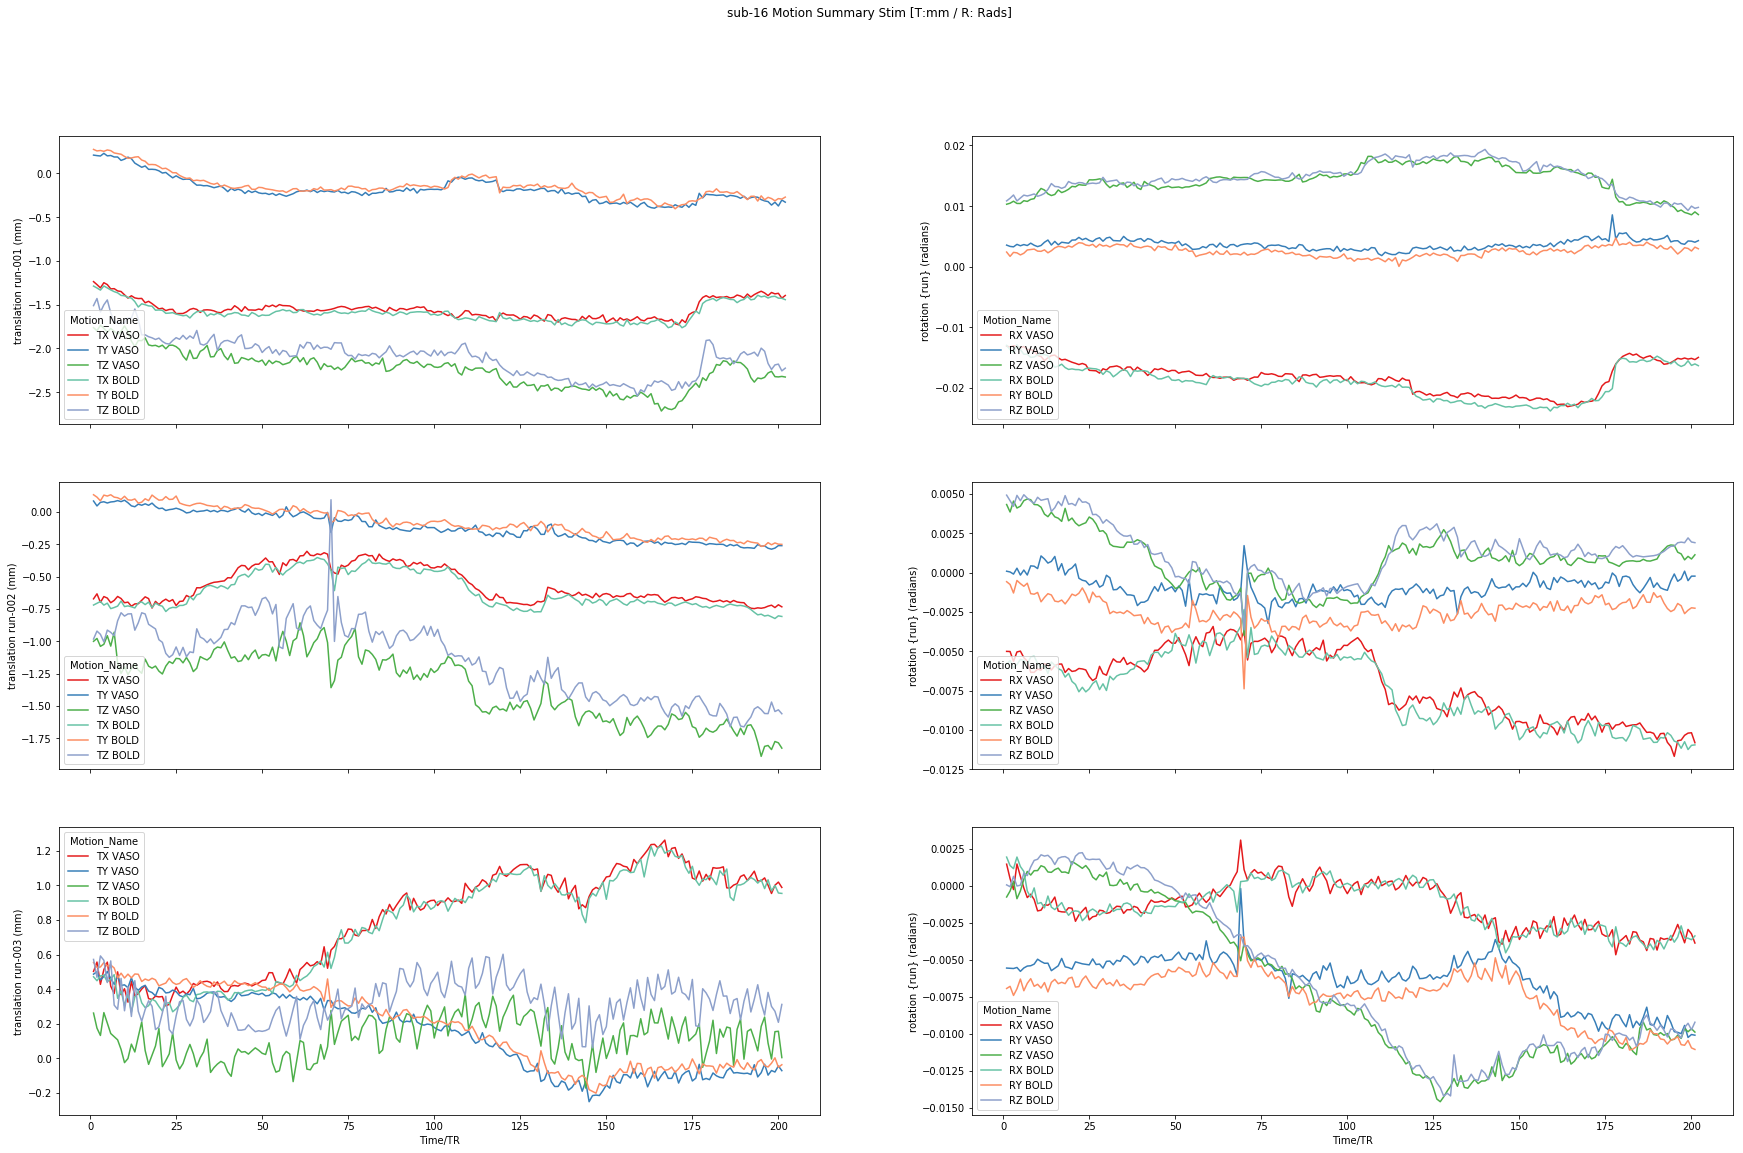

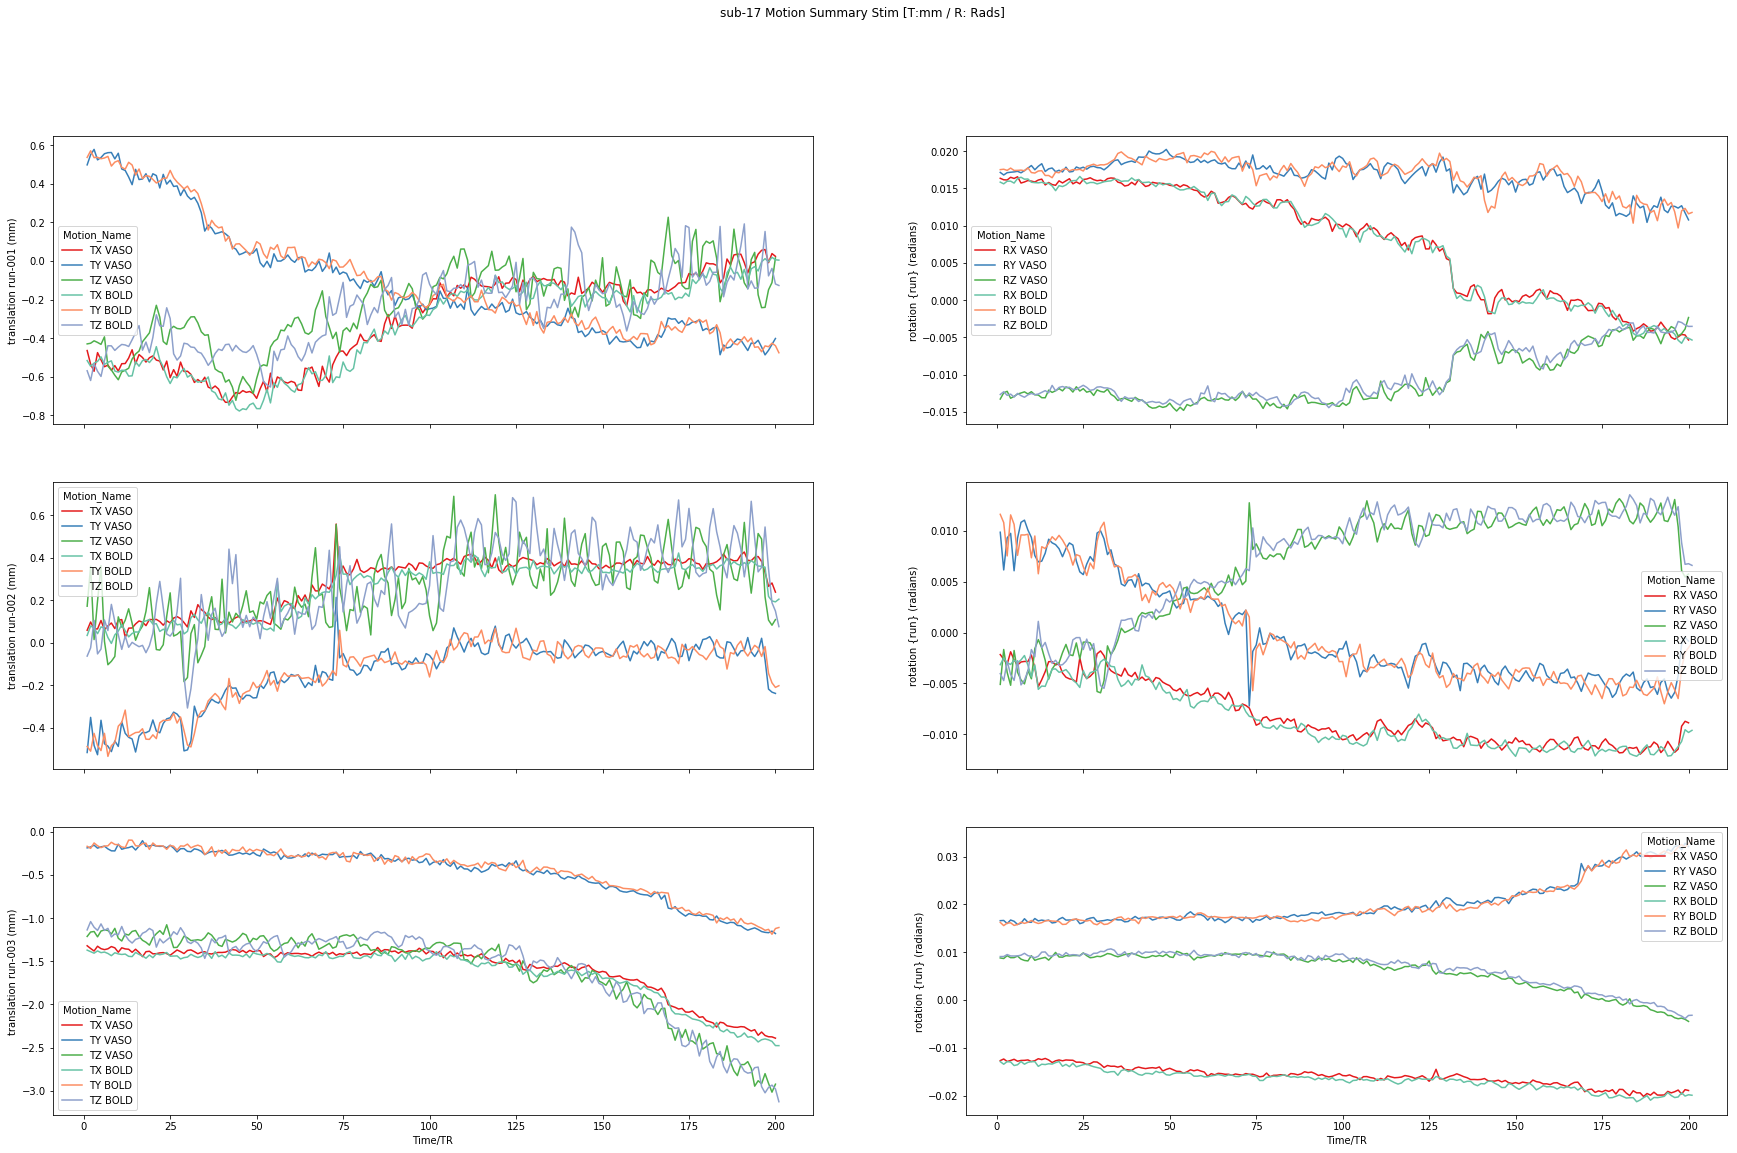

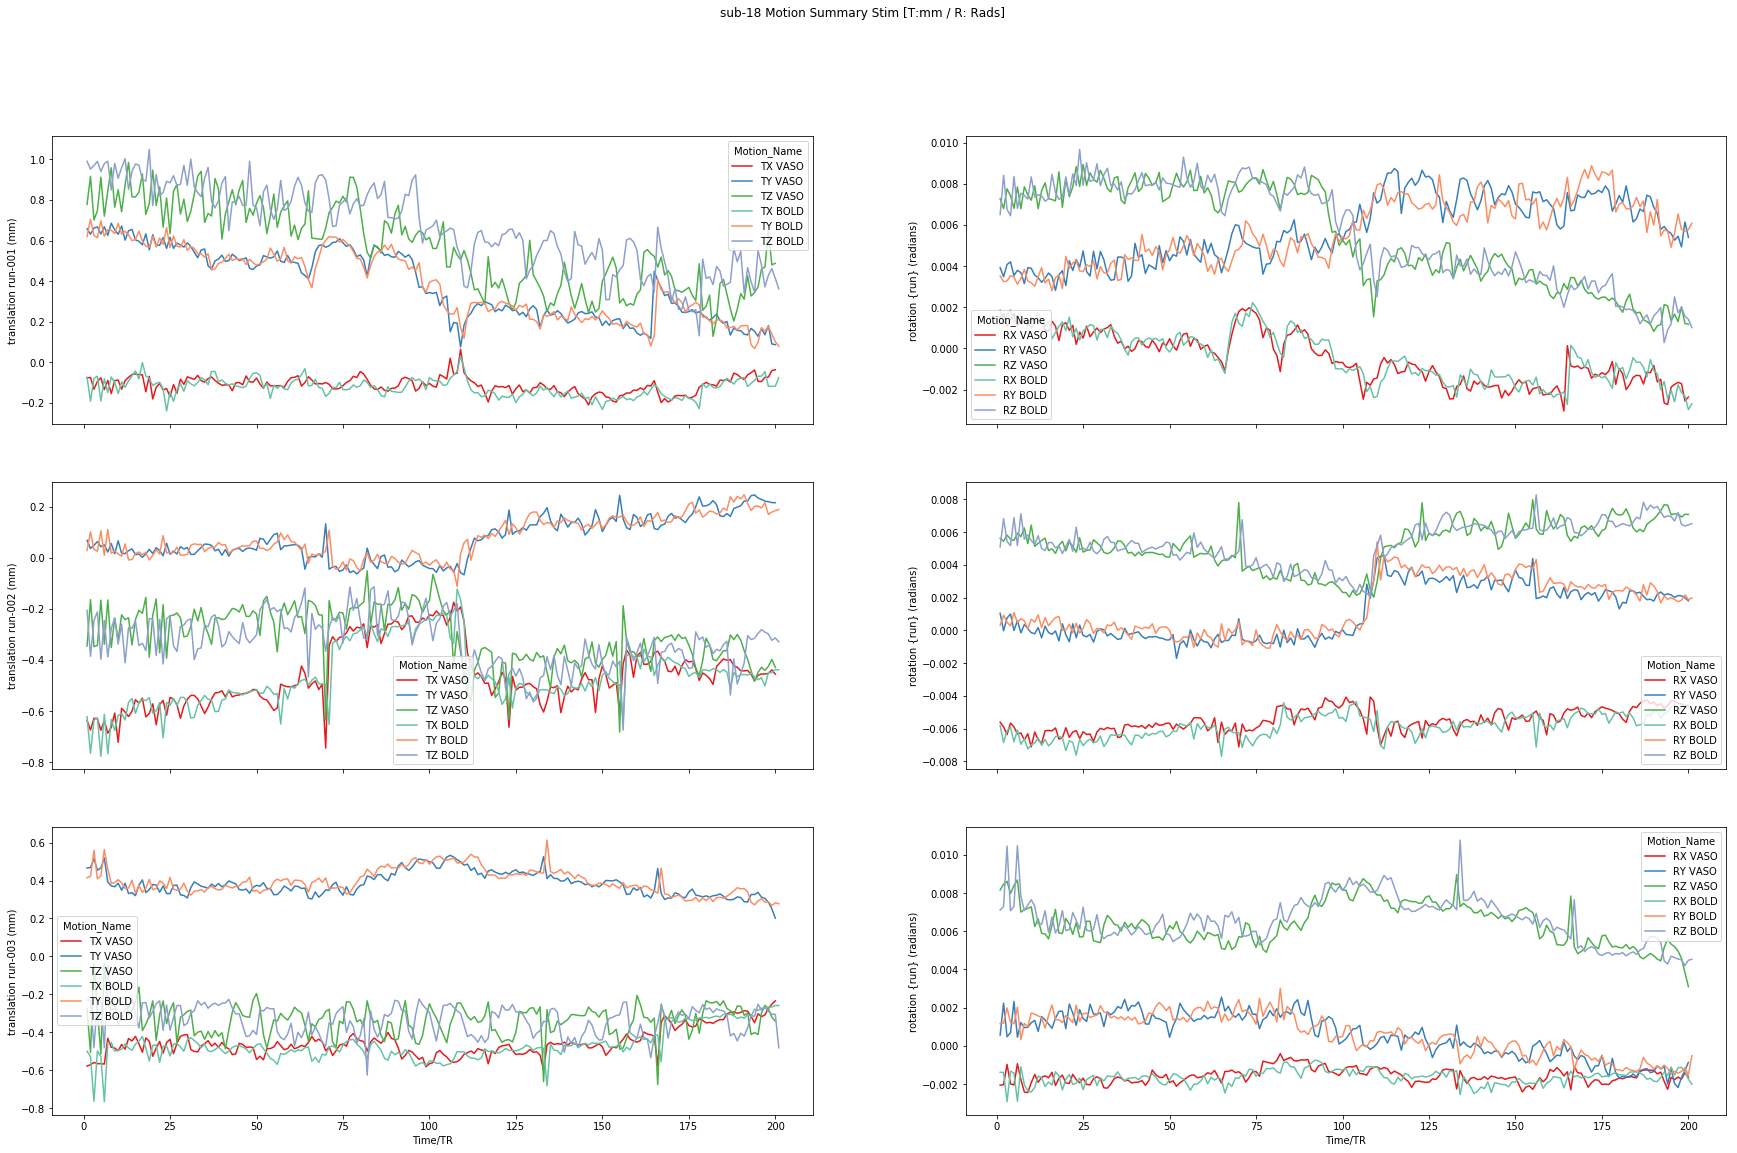

In [59]:
for sub in subs:
    
    stimMotion = pd.read_csv(root + f'/derivatives/quality_assessmen/{sub}motionParametersStim.csv')
    nrRuns = len(np.unique(stimMotion['run']))
    print(sub)
    print(nrRuns)
    fig, axes = plt.subplots(nrRuns, 2,sharex=True,figsize=(30,6*nrRuns))
    plt.suptitle('%s Motion Summary Stim [T:mm / R: Rads]'%(sub))


    
    for run,n in zip(np.unique(stimMotion['run']),range(nrRuns)):
        
        stimMotion_rot_VASO = stimMotion.loc[(stimMotion['Motion_Name'].str.contains("R") == 1)&(stimMotion['subject']==sub)&(stimMotion['modality']=='VASO')&(stimMotion['run']==run)].dropna()
        stimMotion_trans_VASO = stimMotion.loc[(stimMotion['Motion_Name'].str.contains("T") == 1)&(stimMotion['subject']==sub)&(stimMotion['modality']=='VASO')&(stimMotion['run']==run)].dropna()

        stimMotion_rot_BOLD = stimMotion.loc[(stimMotion['Motion_Name'].str.contains("R") == 1)&(stimMotion['subject']==sub)&(stimMotion['modality']=='BOLD')&(stimMotion['run']==run)].dropna()
        stimMotion_trans_BOLD = stimMotion.loc[(stimMotion['Motion_Name'].str.contains("T") == 1)&(stimMotion['subject']==sub)&(stimMotion['modality']=='BOLD')&(stimMotion['run']==run)].dropna()


        if nrRuns == 1:
            sns.lineplot(ax=axes[0], x='Time/TR',y='Motion',data=stimMotion_trans_VASO, hue='Motion_Name', palette = 'Set1')
            sns.lineplot(ax=axes[0], x='Time/TR',y='Motion',data=stimMotion_trans_BOLD, hue='Motion_Name', palette = 'Set2')

            sns.lineplot(ax=axes[1], x='Time/TR',y='Motion',data=stimMotion_rot_VASO,hue='Motion_Name', palette = 'Set1')
            sns.lineplot(ax=axes[1], x='Time/TR',y='Motion',data=stimMotion_rot_BOLD,hue='Motion_Name', palette = 'Set2')


            axes[0].set_ylabel(f"translation {run} (mm)")

            axes[1].set_ylabel("rotation {run} (radians)")
        
        else:
            sns.lineplot(ax=axes[n, 0], x='Time/TR',y='Motion',data=stimMotion_trans_VASO,hue='Motion_Name', palette = 'Set1')
            sns.lineplot(ax=axes[n, 0], x='Time/TR',y='Motion',data=stimMotion_trans_BOLD,hue='Motion_Name', palette = 'Set2')

            sns.lineplot(ax=axes[n, 1], x='Time/TR',y='Motion',data=stimMotion_rot_VASO,hue='Motion_Name', palette = 'Set1')
            sns.lineplot(ax=axes[n, 1], x='Time/TR',y='Motion',data=stimMotion_rot_BOLD,hue='Motion_Name', palette = 'Set2')


            axes[n, 0].set_ylabel(f"translation {run} (mm)")

            axes[n, 1].set_ylabel("rotation {run} (radians)")
    plt.savefig('/home/sebastian/Desktop/%s_motionStim.jpg'%(sub), bbox_inches = 'tight', pad_inches = 0)

### Z-transforming motion parameters

To make the motion traces usable for our GLM analysis, we have to z-transform them (why actually?).

In [ ]:
for sub in subs:
    TX_Z = stats.zscore(pd_ses['Motion'].loc[(pd_ses['Motion_Name']=='TX')&(pd_ses['subject']==sub)])
    TY_Z = stats.zscore(pd_ses['Motion'].loc[(pd_ses['Motion_Name']=='TY')&(pd_ses['subject']==sub)])
    TZ_Z = stats.zscore(pd_ses['Motion'].loc[(pd_ses['Motion_Name']=='TZ')&(pd_ses['subject']==sub)])

    RX_Z = stats.zscore(pd_ses['Motion'].loc[(pd_ses['Motion_Name']=='RX')&(pd_ses['subject']==sub)])
    RY_Z = stats.zscore(pd_ses['Motion'].loc[(pd_ses['Motion_Name']=='RY')&(pd_ses['subject']==sub)])
    RZ_Z = stats.zscore(pd_ses['Motion'].loc[(pd_ses['Motion_Name']=='RZ')&(pd_ses['subject']==sub)])
    
    TX_Z_new = []
    TY_Z_new = []
    TZ_Z_new = []
    
    RX_Z_new = []
    RY_Z_new = []
    RZ_Z_new = []

    for n in range(len(TX_Z)):
        TX_Z_new.append(TX_Z[n])
        TX_Z_new.append((TX_Z[n]+TX_Z[n])/2)
        
        TY_Z_new.append(TY_Z[n])
        TY_Z_new.append((TY_Z[n]+TY_Z[n])/2)
        
        TZ_Z_new.append(TZ_Z[n])
        TZ_Z_new.append((TZ_Z[n]+TZ_Z[n])/2)
        
        
        RX_Z_new.append(RX_Z[n])
        RX_Z_new.append((RX_Z[n]+RX_Z[n])/2)
        
        RY_Z_new.append(RY_Z[n])
        RY_Z_new.append((RY_Z[n]+RY_Z[n])/2)
        
        RZ_Z_new.append(RZ_Z[n])
        RZ_Z_new.append((RZ_Z[n]+RZ_Z[n])/2)
    
    sub_motion_matrix = pd.DataFrame({'TX_Z':TX_Z_new, 'TY_Z':TY_Z_new, 'TZ_Z':TZ_Z_new, 'RX_Z':RX_Z_new, 'RY_Z':RY_Z_new, 'RZ_Z':RZ_Z_new})
    sub_motion_matrix.to_csv( '/media/sebastian/elements/data/s1_anfunco_analysis/%s/func/vaso/rest_3b/motion/%s_motionparams.txt'%(sub,sub), header=None, index=None, sep=' ')

In [ ]:
# load saved file

sub_motion_matrix = pd.read_csv('/media/sebastian/elements/data/s1_anfunco_analysis/sub05/func/vaso/rest_3b/motion/sub05_motionparams.txt', header=None,  sep=' ') 
# Preview the first 5 lines of the loaded data 
sub_motion_matrix.columns = ['TX_Z', 'TY_Z', 'TZ_Z', 'RX_Z', 'RY_Z', 'RZ_Z']

sub_motion_matrix.head()

In [ ]:
TX_Z_new = []

for n in range(len(TX_Z)):
    TX_Z_new.append(TX_Z[n])
    TX_Z_new.append((TX_Z[n]+TX_Z[n])/2)

**Importantly**, we also have to upsample the motion traces because we calculated them on the "raw" data, while the preprocessed data is temporally upsampled. 

In [ ]:
f = interpolate.interp2d(TX_Z, kind='linear')


## Quality Assessment

Especially in high resolution fMRI, rigurous quality controls are necessary to evaulate the data. In the following we will go through various procedures to give a rough estimate of the data-quality.

- Mean image
- TSNR
- skew
- kurtosis
- FD
- Motion assessment a la Marquardt

For some of these measures, we have to do a bit more processing. Therefore, I will first continue with the steps outlined in Renzo's BOLD-correction scripts.

### Mean image, tSNR, skew and kurtosis

in this [blog-post](https://layerfmri.com/2020/04/06/qa/), Renzo describes different measures of quality assessment for layer fMRI.


**IMPORTANT**

This process uses a mask containing the postcentral gyrus plus a lot of other stuff. Therefore, it can be made more precise by using a GM-mask.

In [ ]:
measures = ['mean', 'tSNR','skew','kurt']


for sub in subs:
    for measure in 
    for modality in ['BOLD_intemp', 'VASO_LN']:
        data = nb.load('/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-02/func/rest/sub-02_rest3b_run-001_VASO_LN_tSNR.nii').get_fdata()

In [ ]:
%%capture
measures = ['mean', 'tSNR']
colorMaps = [cm.Greys_r,'hot']



for modality in ['BOLD_intemp', 'VASO_LN']:
    for measure,colorMap in zip(measures, colorMaps):
        fig, axes = plt.subplots(len(subs), 1, figsize=(5,40), sharex=True, sharey=True)

        for sub,k in zip(subs,range(len(subs))):
            data = nb.load(f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/func/rest/{sub}_rest3b_run-001_{modality}_{measure}.nii').get_fdata()
            data = data[:,:,10,0]
            rotated_img = ndimage.rotate(data, 90)
            im = axes[k].imshow(rotated_img, cmap=colorMap)
            plt.axis('off')
            #plt.colorbar()
            #fig.colorbar(rotated_img, ax=axes[k])
            axes[k].axis('off')
            if measure == 'tSNR':
                cbar = fig.colorbar(im,ax=axes[k], ticks=[rotated_img.min(), rotated_img.max()])
                cbar.ax.tick_params(size=0)
                
        plt.savefig(f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/qualityAssessment/{modality}_{measure}_map', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
%%capture
measures = ['skew','kurt']
colorMaps = [cm.Greys_r, cm.Greys_r]



for modality in ['BOLD_intemp', 'VASO_LN']:
    for measure,colorMap in zip(measures, colorMaps):
        fig, axes = plt.subplots(len(subs), 1, figsize=(5,40), sharex=True, sharey=True)

        for sub,k in zip(subs,range(len(subs))):
            data = nb.load(f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/func/rest/{sub}_rest3b_run-001_{modality}_{measure}.nii').get_fdata()
            data = data[:,:,10,0]
            rotated_img = ndimage.rotate(data, 90)
            #plt.colorbar()
            #fig.colorbar(rotated_img, ax=axes[k])
            axes[k].axis('off')

            im = axes[k].imshow(rotated_img, cmap=colorMap, vmin = -1, vmax = 1)
            

            cbar = fig.colorbar(im,ax=axes[k], ticks=[-1, 1])
            cbar.ax.tick_params(size=0)




                
        plt.savefig(f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/qualityAssessment/{modality}_{measure}_map', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
subList = []
valList = []
modalityList = []
measureList = []


for sub in subs:
    for modality in ['BOLD_intemp', 'VASO_LN']:
        
        for measure in ['tSNR','skew','kurt']:

            data = nb.load(root + f'/derivatives/{sub}/func/rest/{sub}_rest3b_run-001_{modality}_{measure}.nii').get_fdata()


            mask = nb.load(root + f'/derivatives/{sub}/{sub}_moma.nii').get_fdata()

            data_masked = np.multiply(data[:,:,:,0], mask)[np.multiply(data[:,:,:,0], mask)!=0]


            subList.append([str(sub) for i in range(len(data_masked))])
            modalityList.append([str(modality) for i in range(len(data_masked))])
            measureList.append([str(measure) for i in range(len(data_masked))])
            valList.append(data_masked)

subList = [item for sublist in subList for item in sublist]
modalityList = [item for sublist in modalityList for item in sublist]
measureList = [item for sublist in measureList for item in sublist]
valList = [item for sublist in valList for item in sublist]


subList = np.array(subList).flatten()
subList = subList.reshape((subList.size,-1)) 

valList = np.array(valList).flatten()
valList = valList.reshape((valList.size,-1)) 

measureList = np.array(measureList).flatten()
measureList = measureList.reshape((measureList.size,-1)) 

modalityList = np.array(modalityList).flatten()
modalityList = modalityList.reshape((modalityList.size,-1)) 
    

QA = pd.DataFrame({'subject': subList[:,0], 'val': valList[:,0], 'measure': measureList[:,0], 'modality': modalityList[:,0]})

In [ ]:
def add_mean_line(data, var=None, **kws):
    
    # If no variable provided skip adding mean line
    if not var: return
    
    #Calculate mean for each group
    m = np.mean(data[var])
    
    #Get current axis
    ax = plt.gca()
    
    #add line at group mean
    ax.axvline(m, color='black', lw=2, ls='--')
    
    #annotate group mean
    #x_pos=0.65
    #if m > 5000: x_pos=0.2
    #ax.text(x_pos, 0.7, f'mean={m:.0f}', 
    #        transform=ax.transAxes,   #transforms positions to range from (0,0) to (1,1)
    #        color='maroon', fontweight='bold', fontsize=12)

In [ ]:
g = sns.FacetGrid(QA.loc[(QA['measure']=='tSNR')], row='subject',hue='modality')
g.map_dataframe(sns.kdeplot, "val", fill=True)
g.map_dataframe(add_mean_line, var='val')
g.add_legend()

In [ ]:
measures = ['tSNR','skew','kurt']


for measure,n in zip(measures, range(len(measures))):
    fig, axes = plt.subplots(len(subs), 1, figsize=(5,40), sharex=True, sharey=True)

    for sub,k in zip(subs,range(len(subs))):
            sns.kdeplot(ax = axes[k], data= QA.loc[(QA['measure']==measure)&(QA['subject']==sub)], x="val", hue='modality', fill=True)           
            #axes[0].set_title(f'{measure}', fontsize=24)
            axes[-1].set_xlabel(f'{measure}', fontsize=20)
            if measure != 'tSNR':
                axes[0].set_xlim(-1,1)
                
                
                
    plt.savefig(f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/qualityAssessment/{measure}', bbox_inches = 'tight', pad_inches = 0)

### Compute framewise displacements

In [ ]:
sub_FD = []
timepoints = []
subjects=[]
mods = []

for sub in subs:
    
    for modality in modalities:
        
        TX = pd_ses['Motion'].loc[(pd_ses['Motion_Name'].str.contains("TX") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()
        TY = pd_ses['Motion'].loc[(pd_ses['Motion_Name'].str.contains("TY") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()
        TZ = pd_ses['Motion'].loc[(pd_ses['Motion_Name'].str.contains("TZ") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()

        RX = pd_ses['Motion'].loc[(pd_ses['Motion_Name'].str.contains("RX") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()
        RY = pd_ses['Motion'].loc[(pd_ses['Motion_Name'].str.contains("RY") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()
        RZ = pd_ses['Motion'].loc[(pd_ses['Motion_Name'].str.contains("RZ") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()

        for n in range(len(TX)-1):
            FD_trial = abs(TX[n]-TX[n+1])+abs(TY[n]-TY[n+1])+abs(TZ[n]-TZ[n+1])+abs((50*RX[n])-(50*RX[n+1]))+abs((50*RY[n])-(50*RY[n+1]))+abs((50*RZ[n])-(50*RZ[n+1]))
            sub_FD.append(FD_trial)
            timepoints.append(n)
            subjects.append(sub)
            mods.append(modalitiesDict[modality])
        

FDs = pd.DataFrame({'subject':subjects, 'volume':timepoints, 'FD':sub_FD, 'modality': mods})

In [ ]:
sns.color_palette("tab10")[0]

In [ ]:
fig, axes = plt.subplots(len(subs), 1, figsize=(5,40), sharex=True, sharey=True)

for sub,k in zip(subs,range(len(subs))):
        sns.violinplot(ax = axes[k], data= FDs.loc[FDs['subject']==sub], inner = 'quartile', x='subject',y='FD', hue='modality', split=True, alpha = 0.5, palette = [sns.color_palette("tab10")[1], sns.color_palette("tab10")[0]])           
        axes[-1].set_xlabel(f'Framewise discplacement', fontsize=20)
        axes[k].set_ylabel(f'FD (mm)', fontsize=20)
        
        if not k == len(subs):
            axes[k].set_xticks([])
            axes[k].set_xlabel('')
        
        #if not k == len(subs):
         #   axes[k].legend([],[], frameon=False)
            





plt.savefig(f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/qualityAssessment/FDs', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig  = plt.figure(figsize=(12,8))
plt.title('Framewise Displacements (rest)', fontsize=24)

sns.violinplot(x='subject',y='FD',data=FDs, hue = 'modality')
plt.ylabel("FD (mm)", fontsize=20)
plt.xlabel("participant", fontsize=20)

# plt.savefig('/home/sebastian/Desktop/resting_state_FD.jpg')

In [ ]:
fig, axes = plt.subplots(len(subs), 1,sharex=True,sharey=True, figsize = (20,10))

for sub,n in zip(subs,range(len(subs))):
    sns.lineplot(ax = axes[n], x='volume',y='FD',data=FDs.loc[FDs['subject']==sub],hue = 'modality')



# plt.savefig('/home/sebastian/Desktop/resting_state_FD_subplots.jpg')

In [ ]:
fig  = plt.figure(figsize=(12,8))
plt.title('Framewise Displacements')

sns.violinplot(x='subject',y='FD',data=FDs, inner="stick")
plt.ylabel("FD (mm)")

plt.savefig('/home/sebastian/Desktop/resting_state_FD.jpg')

## Anatomical processing


### Averaging of the 3 high resolution slabs using ITK-SNAP

To increase the SNR, I first averaged the 3 high resolution slabs we acquired.

In [3]:
root = '/media/sebastian/Data/S1ANFUNCO/raw_data'

In [25]:
restRuns = sorted(glob.glob(root + '/S1ANFUNCO_BIDS/sub-*/ses-00*/func/sub-*_ses-00*_task-rest*_cbv.nii.gz'))
subList = [i[-47:-41] for i in restRuns]

In [ ]:
for sub in subList[1:]:
    
    # Define output folder
    outFolder = f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/anat'
    
    # look for 3 anatomical images.
    imgs = sorted(glob.glob(root + f'S1ANFUNCO_BIDS/{sub}/ses-00*/anat/*_ses-00*_highres-mp2rage_run-00*_uni.nii.gz'))
    
    # Read reference image.
    fixed = ants.image_read(imgs[0])
    
    # Save it for easy processing in a step below
    ants.image_write(fixed, outFolder + f'/1.nii', ri=False)
    
    # Register images 2 and 3
    for img,n in zip(imgs[1:],range(2,len(imgs)+1)):
        
        moving = ants.image_read(img)
        mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='Rigid' )
        warped_moving = mytx['warpedmovout']
        
        # Save it for easy processing in a step below
        ants.image_write(warped_moving, outFolder + f'/{n}.nii', ri=False)
    
    # Load 3 anatomical images for averaging
    img1 = nb.load(outFolder + f'/1.nii').get_fdata()
    img2 = nb.load(outFolder + f'/2.nii').get_fdata()
    img3 = nb.load(outFolder + f'/3.nii').get_fdata()

    # Average 3 anatomical images to increase SNR
    avg = np.add(img1, img2)
    avg = np.add(avg, img3)
    avg = np.divide(avg, 3)
    ni_img = nb.Nifti1Image(avg, nb.load(outFolder + f'/1.nii').affine)
    nb.save(ni_img, outFolder+ f'/{sub}_highres-mp2rage_uni_average.nii')
    
    # Bias field correction
    image = ants.image_read(outFolder+ f'/{sub}_highres-mp2rage_uni_average.nii')
    image_n4 = ants.n4_bias_field_correction(image)
    
    # Save corrected image
    ants.image_write(image_n4, outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected.nii', ri=False)
    
    # Delete intermediate steps.
    for n in range(1,len(imgs)+1):
        os.remove(outFolder + f"/{n}.nii")

In [ ]:
# For sub-02 the acquisition of anatomical data was a bit messy due to the various sessions, 
# therefore I will do it manually here.

outFolder = f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-02/anat'

# Bias field correction
image = ants.image_read(outFolder+ f'/sub-02_highres-mp2rage_uni_average.nii.gz')
image_n4 = ants.n4_bias_field_correction(image)
    
# Save corrected image
ants.image_write(image_n4, outFolder+ f'/sub-02_highres-mp2rage_uni_average_N4corrected.nii', ri=False)

### Voxel reduction

Because we are only interested in the postcentral gyrus, we will reduce our voxels with several measures.
First, we will use brain masks and then crop our data.

#### Brain mask

Automatic brain extraction is often problematic. Therefore, I manually drew outlines of the brain in every 3rd slice and dilated them with the following code:

In [ ]:
for sub in subList:
    outFolder = f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/anat'
    # load data
    nii = load(outFolder + f'/{sub}_highres-mp2rage_uni_average_N4corrected_brainMask.nii.gz')

    basename = nii.get_filename().split(os.extsep, 1)[0]
    dirname = os.path.dirname(nii.get_filename())
    data = nii.get_fdata()

    # perform closing
    data = morphology.binary_dilation(data, iterations=3)
    data = morphology.binary_erosion(data, iterations=3)

    # perform opening
    #data = morphology.binary_erosion(data, iterations=1)
    #data = morphology.binary_dilation(data, iterations=1)

    # save as nifti
    out = Nifti1Image(data, header=nii.header, affine=nii.affine)
    save(out, basename + "_opening_closing.nii.gz")


    print('Morphology operations are done.')


Then we can multiply the anatomical image with the mask.

In [ ]:
for sub in subList:
    outFolder = f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/anat'
    anatData = nb.load(outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected.nii').get_fdata()
    maskData = nb.load(outFolder + f'/{sub}_highres-mp2rage_uni_average_N4corrected_brainMask_opening_closing.nii.gz').get_fdata()
    
    # Multiply with binary brain mask to get rid of non-brain voxels.
    masekdData = np.multiply(anatData, maskData)
    
    # save as nifti
    ni_img = nb.Nifti1Image(masekdData, nb.load(outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected.nii').affine)
    nb.save(ni_img, outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain.nii')


#### Cropping

To further reduce our voxels, we copped the data to our area of interest. This involved some visual inspection. The coordinates.

In [ ]:
boundariesDict = {'sub-02': [80, 170, 75, 115, 5, 51],
                  'sub-05': [110, 160, 60, 125, 7, 47],
                  'sub-06': [100, 160, 70, 90, 9, 46],
                  'sub-07': [100, 180, 70, 120, 10, 45],
                  'sub-09': [75, 175, 110, 90, 7, 47],
                  'sub-10': [90, 175, 80, 100, 9, 45],
                  'sub-12': [90, 175, 60, 110, 4, 48],
                  'sub-15': [85, 165, 80, 110, 4, 49],
                  'sub-16': [90, 160, 65, 125, 4, 51],
                  'sub-17': [80, 155, 95, 115, 4, 48],
                  'sub-18': [65, 170, 90, 115, 4, 51]
                 }



In [ ]:
from nipype.interfaces.fsl import ExtractROI

for sub in subList:
    outFolder = f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/anat'

    anatFile = outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain.nii'

    # Apparently, the fslroi wrapper in nipype wants an existing file as output filename (?). Therefore, I will create one with the same dimensions.
    tmpFile = nb.load(anatFile)
    tmp = Nifti1Image(tmpFile.get_fdata(), header=tmpFile.header, affine=tmpFile.affine)
    save(tmp, outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz')


    fslroi = ExtractROI(in_file=anatFile, roi_file= outFolder+ f'/{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz', 
                        x_min = boundariesDict[sub][0], x_size = boundariesDict[sub][1], 
                        y_min = boundariesDict[sub][2], y_size = boundariesDict[sub][3],
                        z_min = boundariesDict[sub][4], z_size = boundariesDict[sub][5]
                       )

    out = fslroi.run()

### Segmentation

We started the segmentation process with an automatic segmentation using FSL FAST:

In [30]:
outFolders

['/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-02/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-05/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-06/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-07/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-09/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-10/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-12/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-15/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-16/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-17/func/rest',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-18/func/rest']

In [31]:
from nipype.interfaces import fsl

for sub in subList:
    fastr = fsl.FAST()
    fastr.inputs.in_files = f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/anat/{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz'
    out = fastr.run()

The segmetntation was then manually corrected and saved as

'{sub}_highres-mp2rage_uni_average_N4corrected_brain_trunc_pveseg_corrected.nii.gz'

### Registration

For the registration, I manually matched the average UNI images with the upsampled anatomy in EPI space. The resulting matrix was saved as "initial_matrix".

To further improve our registration, we will use a registration mask. Fortunately, we happen to have one already from the initial motion correction. We just have to upsample it so it machtes out target space.

We'll do that like so:

In [ ]:
%%bash -s "{" ".join(subs)}" "$root"

for sub in $1
do
cd $2/derivatives/$sub

echo Upsampling $sub moma
delta_x=$(3dinfo -di "$sub"_moma.nii)
delta_y=$(3dinfo -dj "$sub"_moma.nii)
delta_z=$(3dinfo -dk "$sub"_moma.nii)
sdelta_x=$(echo "((sqrt($delta_x * $delta_x) / 5))"|bc -l)
sdelta_y=$(echo "((sqrt($delta_y * $delta_y) / 5))"|bc -l)
sdelta_z=$(echo "((sqrt($delta_z * $delta_z) / 1))"|bc -l)
# here I only upscale in 2 dimensions.

3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix "$sub"_moma_scaled.nii -input "$sub"_moma.nii

done

We want to register the MP2RAGE anatomy to the T1 weighted images in EPI space. In previous steps, we already calculated them for individual runs. However, we can imporve the images by taking into account all runs we acquired of a given subject.

In [ ]:
from nipype.interfaces import afni

for sub in subList:
    inputFiles = sorted(glob.glob(f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/func/*/{sub}_*_run-00*_moco_*ulled.nii'))
    tcat = afni.TCat()
    tcat.inputs.in_files = inputFiles
    tcat.inputs.out_file= f'/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/{sub}/func/combined.nii'

    res = tcat.run()

In [ ]:
%%bash -s "{" ".join(subList)}"

List1=$1

subsList=($List1)

len=${#subsList[@]}
 

for (( j=0; j<$len; j++ ))
do

echo Current subject: ${subsList[$j]}

cd /media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/${subsList[$j]}/func

3dTstat -cvarinv -overwrite -prefix ${subsList[$j]}_EPI_T1w.nii combined.nii
rm combined.nii

N4BiasFieldCorrection -d 3 -i ${subsList[$j]}_EPI_T1w.nii -o ${subsList[$j]}_EPI_T1w_N4Corrected.nii


echo "Upsampling"
delta_x=$(3dinfo -di ${subsList[$j]}_EPI_T1w_N4Corrected.nii)
delta_y=$(3dinfo -dj ${subsList[$j]}_EPI_T1w_N4Corrected.nii)
delta_z=$(3dinfo -dk ${subsList[$j]}_EPI_T1w_N4Corrected.nii)
sdelta_x=$(echo "((sqrt($delta_x * $delta_x) / 5))"|bc -l)
sdelta_y=$(echo "((sqrt($delta_y * $delta_y) / 5))"|bc -l)
sdelta_z=$(echo "((sqrt($delta_z * $delta_z) / 1))"|bc -l)
# here I only upscale in 2 dimensions.

3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix ${subsList[$j]}_EPI_T1w_N4Corrected_scaled.nii -input ${subsList[$j]}_EPI_T1w_N4Corrected.nii

done

In [63]:
subList

['sub-02',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-09',
 'sub-10',
 'sub-12',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18']

In [64]:
%%bash -s "{" ".join(subList)}" "$root"

List1=$1

subsList=($List1)

len=${#subsList[@]}

for (( j=0; j<$len; j++ ))
do

cd $2/derivatives/${subsList[$j]}/anat/registration

echo Current participant: ${subsList[$j]}
echo Fixed: $2/derivatives/${subsList[$j]}/func/${subsList[$j]}_EPI_T1w_N4Corrected_scaled.nii
echo Moving: ../${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz
echo ###

antsRegistration \
--verbose 1 \
--dimensionality 3  \
--float 0  \
--collapse-output-transforms 1  \
--interpolation BSpline[5] \
--output [registered1_,registered1_Warped.nii,1]  \
--use-histogram-matching 0  \
--winsorize-image-intensities [0.005,0.995]  \
--initial-moving-transform initial_matrix.txt \
--transform SyN[0.1,3,0]  \
--metric CC[$2/derivatives/${subsList[$j]}/func/${subsList[$j]}_EPI_T1w_N4Corrected_scaled.nii, ../${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz,1,2]  \
--convergence [60x10,1e-6,10]  \
--shrink-factors 2x1  \
--smoothing-sigmas 1x0vox  \
-x ../../${subsList[$j]}_moma_scaled.nii

antsApplyTransforms \
--interpolation BSpline[5] \
-d 3 -i ../${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz \
-r $2/derivatives/${subsList[$j]}/func/${subsList[$j]}_EPI_T1w_N4Corrected_scaled.nii \
-t registered1_1Warp.nii.gz \
-t registered1_0GenericAffine.mat \
-o ${subsList[$j]}_highres-mp2rage_uni_average_N4corrected_brain_trunc_registered.nii

done

Current participant: sub-02
Fixed: /media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-02/func/sub-02_EPI_T1w_N4Corrected_scaled.nii
Moving: ../sub-02_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz

All_Command_lines_OK
Using double precision for computations.
The composite transform comprises the following transforms (in order): 
  1. initial_matrix.txt (type = MatrixOffsetTransformBase)
  Reading mask(s).
    Registration stage 0
      Fixed mask = ../../sub-02_moma_scaled.nii
  number of levels = 2
  fixed image: /media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/sub-02/func/sub-02_EPI_T1w_N4Corrected_scaled.nii
  moving image: ../sub-02_highres-mp2rage_uni_average_N4corrected_brain_trunc.nii.gz
Dimension = 3
Number of stages = 1
Use Histogram Matching false
Winsorize image intensities true
Lower quantile = 0.005
Upper quantile = 0.995
Stage 1 State
   Image metric = CC
     Fixed image = Image (0x55d642e7e6e0)
  RTTI typeinfo:   itk::Image<double, 3u>
  Reference

#### Visual inspection of registration.

sub-02 - not good
sub-05 - very bad
sub-06
sub-07
sub-09
sub-10
sub-12
sub-15
sub-16
sub-17
sub-18

